# Facilitating Sensemaking in Learner-centred Feedback with NLP

Date: 16/06/2022

Version: 2.0

Environment: Python 3.9.16 and Anaconda 4.11.0 (64-bit)

# RQ1: To what extent does current feedback practice align with the Sensemaking aspect of learner-centred feedback?

This is going to be a multi-dimensonal analysis of feedback data sourced from Monash University's Moodle database. Prior to implementing this notebook content, the data has been wrangled, filtered and manipulated into its final form in a file called `stage2.csv` which can be found in the same directory as this notebook.

## Part 1: Text Counts and Complexities

### 1. Importing the Libraries and the Data

Before starting the process of answering the above research question, we need to load the requried Python libraries and the cleaned feedback dataset. We can use the `import` function in Python to load them one by one.

In [1]:
# Importing the required libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import defaultdict, Counter
import pandas as pd
import string


# Installing the textstat library
!pip install textstat

# Loading the textstat library
import textstat

In [2]:
# Hiding the Jupyter notebook warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Downloading the additional NLTK dictionaries
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 2. Importing the Cleaned Feedback Data

We can use the `Pandas` library to load the feedback data into a dataframe. We will manipulate this dataframe in two ways:

**1**. Firstly, we have a combination of rubrics in the Rubric column. We can split them up such that every row of the rubric column contains only one rubric. The idea is to create a seaprate version of the data where every individual rubric can be counted in totality including its multi-rubric occurences and its singular occurences. We can make this into a new dataframe to keep the original dataframe as it is.

**2**: From the new dataframe created in step 1, we can create a third dataframe, this time containing only one of the three components of feedback. Later when we perform different operations with this data, the occurences will be counted at a component level that includes the counts of all the rubrics.

Overall, throughout this notebook, we will perform operations on the following views of the data:

- Multi-Rubric and Single Rubric Occurrences: This included:
    - Unique occurrences of a combination of rubrics for a single sentence or piece of feedback. For example, (Sensemaking 1 & Impact 1) or (Agency 2 & Sensemaking 2).
    - Unique occurrences of each rubric.

- Total Rubric Data: This referred to all occurrences of each rubric inclusive of singular occurrences and rubric combinations.

 - Component Level Data: Component level data contained the total number of times the component occurs in the data, inclusive of all its singular rubric occurrences and rubric combinations. Component refers to Sensemaking, Future Impact and Support Agency (Ryan et al., 2021).
 

**Naming Conventions**: For better understanding, please note the naming convention being used for the data of each granularity:

- Multi-rubric Data: `multi_rubric`
- Single occurence rubric data: `data_non_multi_rubric`
- Total rubric data: `data_rubric`
- Component level data: `data_component`

In [4]:
# Loading the clean feedback csv file into a dataframe
data_feed = pd.read_csv('./LabelledFeedback/stage2.csv')

# Dropping the unnamed index column
data_feed = data_feed.drop(['Unnamed: 0','SentenceLabelRem'], axis=1)

# Changing the name of the raw parsed sentence column
data_feed = data_feed.rename(columns = {'SentenceScoreRem':'Sentence'})

# Checking the dataframe
data_feed.head()

,Sentence,Rubric,Score,FeedbackCode
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1,58.33,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3
4,"""Good effort, Please refer to detailed feedbac...",Agency 2&Agency 1,60.60,4


The above data contains 4 columns:

- **Sentence**: This is the feedback text which is presented in naturally written human language. The comments from a single feedback are situated on separate rows due to the nature of the labelling process. For sentences that are a part of the same feedback, the value in the score and feedbackcode columns will be duplicated.
- **Rubric**: This is the rubric or combination of rubric which applies to the corresponding text.
- **Score**: This is the final score that was given to the student along with the feedback.
- **FeedbackCode**: This is an unique identifier for each piece of feedback that was labelled. Values in the Sentence column having the same feedback code belong to the same piece of feedback.

In [5]:
# Generating a copy of the dataframe for manipulating the Rubrics
data_rubric = data_feed.copy()

In [6]:
# Splitting the 'Rubric column values and removing the '&' between different rubrics
data_rubric['Rubric'] = data_rubric['Rubric'].str.split('&')

# Exploding the Rubric column to split it into individual rows for each rubric
data_rubric = data_rubric.explode('Rubric')

# Checking the manipulated dataframe
data_rubric.head()

,Sentence,Rubric,Score,FeedbackCode
0,Yuejing more in depth analysis is required and...,Sensemaking 1,58.33,1
0,Yuejing more in depth analysis is required and...,Impact 1,58.33,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3


In [7]:
# Generating a copy of the rubric split dataframe
data_component = data_rubric.copy()

In [8]:
# Isolating the three components from each rubric
data_component['Rubric'] = data_component['Rubric'].str.rstrip(string.digits)

# Checking the new dataframe
data_component.head()

,Sentence,Rubric,Score,FeedbackCode
0,Yuejing more in depth analysis is required and...,Sensemaking,58.33,1
0,Yuejing more in depth analysis is required and...,Impact,58.33,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact,59.00,2
2,The team submitted the workbook 23 days after ...,Sensemaking,59.00,2
3,Risk assessment and report needs work as discu...,Sensemaking,70.00,3


In [9]:
# Changing the name of the rubric column for the component dataframe
data_component = data_component.rename(columns = {'Rubric':'Component'})

# Checking the dataframe
data_component.head()

,Sentence,Component,Score,FeedbackCode
0,Yuejing more in depth analysis is required and...,Sensemaking,58.33,1
0,Yuejing more in depth analysis is required and...,Impact,58.33,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact,59.00,2
2,The team submitted the workbook 23 days after ...,Sensemaking,59.00,2
3,Risk assessment and report needs work as discu...,Sensemaking,70.00,3


### 3 Observing the Sensemaking Rubric Word and Sentence Counts

We now have two different dataframes, each with a different representation of the components of learner-centred feedback. We will create the multi-rubric combination data later. Firstly, we will observe information about the Sensemaking rubrics and how they differ from the Future Impact and Support Agency rubrics.

As mentioned in the thesis report, Sensemaking has two rubrics, Sensemaking 1 and Sensemaking 2:

- Sensemaking 1 comments highlight specific strengths and weaknesses of the student's task.
- Sensemaking 2 comments highlight the overall strengths and weaknesses of the student's work with respect to the learning outcomes.

#### 3.1 Rubric Counts

We can check the total count for each rubric by using the `value_counts` function.

In [10]:
# Calculating the total value counts of the 'Rubric' column
rubric_count = data_rubric['Rubric'].value_counts()

# Checking the total number of occurences for each rubric
rubric_count

Rubric
Sensemaking 1    2809
Impact 1         1962
Agency 2          664
Sensemaking 2     500
Agency 1          278
Agency 3          116
Impact 2          106
Impact 3          106
Name: count, dtype: int64

We can see that the Sensemaking 1 rubric is the most prevalent rubric in the entire data. The Sensemaking 2 rubric is the fourth most frequenly occuring rubric. Let us compute the percentages for these occurences to have a clearer view.

In [11]:
# Calculating the percentage of total occurences for each rubric 
rubric_percent = round(((rubric_count / len(data_rubric)) * 100),2)

# Checking the rubric percentages
rubric_percent

Rubric
Sensemaking 1    42.94
Impact 1         30.00
Agency 2         10.15
Sensemaking 2     7.64
Agency 1          4.25
Agency 3          1.77
Impact 2          1.62
Impact 3          1.62
Name: count, dtype: float64

The original data contains a column that contains the final score granted to the student. We can compute the average of that score for each rubric as follows:

In [12]:
# Computing the average score per rubric
rubric_average_score = round((data_rubric.groupby('Rubric')['Score'].mean()),2)

 We can create a new dataframe to capture the above information so that it can be easier to view it later. 

In [13]:
# Creating a dataframe for combining the rubric counts and percentages
rubric_occurence = pd.DataFrame({
    
    'Rubric': rubric_count.index,
    'Occurence': rubric_count.values,
    'Percentage': rubric_percent.values,
    'Avg_Score': rubric_average_score.values
})

# Checking the new dataframe
rubric_occurence

,Rubric,Occurence,Percentage,Avg_Score
0,Sensemaking 1,2809,42.94,69.58
1,Impact 1,1962,30.00,80.63
2,Agency 2,664,10.15,73.58
3,Sensemaking 2,500,7.64,68.89
4,Agency 1,278,4.25,64.31
5,Agency 3,116,1.77,63.45
6,Impact 2,106,1.62,71.59
7,Impact 3,106,1.62,73.25


In the next step, we will calculate the word and sentence complexities for these rubrics.

#### 3.2 Word and Sentence Lengths

We can use the `word_tokenize` function from the NLTK library to tokenize the text and then count the number of tokens to produce the word length. Similarly, we can use the `mean` function to compute the average word lengths for each of the Sensemaking rubrics.

In [14]:
# Creating a new column for the average word length
data_rubric['Avg_Word_Length'] = data_rubric['Sentence'].apply(lambda x: len(word_tokenize(x)))

# Computing the average word length across the feedbacks that contains the sensemaking 1 rubric
average_word_length_sense1 \
= data_rubric[data_rubric['Rubric'].str.contains('Sensemaking 1')]['Avg_Word_Length'].mean()

# Computing the average word length across the feedbacks that contains the sensemaking 2 rubric
average_word_length_sense2 \
= data_rubric[data_rubric['Rubric'].str.contains('Sensemaking 2')]['Avg_Word_Length'].mean()

In [15]:
# Checking the average word length for the sensemaking 1 rubric
print('The average word length across the Sensemaking 1 rubric is: ', round(average_word_length_sense1 \
, 2))

# Checking the average word length for the sensemaking 2 rubric
print('The average word length across the Sensemaking 2 rubric is: ', round(average_word_length_sense2 \
, 2))

The average word length across the Sensemaking 1 rubric is:  23.85
The average word length across the Sensemaking 2 rubric is:  16.87


In [16]:
# Checking the average word length column for the total rubric occurences
data_rubric

,Sentence,Rubric,Score,FeedbackCode,Avg_Word_Length
0,Yuejing more in depth analysis is required and...,Sensemaking 1,58.33,1,16
0,Yuejing more in depth analysis is required and...,Impact 1,58.33,1,16
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2,16
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,13
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,10
...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,83.78,895,21
5755,"In part (b), which was more complicated than i...",Sensemaking 1,83.78,895,45
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,83.78,895,10
5757,You made two errors: finding the determinant i...,Sensemaking 1,83.78,895,23


We can reuse the `word_tokenize` function to compute the sentence length of the text.

In [17]:
# Creating a new column to calculate the average sentence length for the total rubric occurrences in the text
data_rubric['Avg_Sentence_Length'] = \
data_rubric['Sentence'].apply(lambda x: sum(len(w) for w in word_tokenize(x)) / len(word_tokenize(x)))

In [18]:
# Rounding off the average sentence length for the total rubric occurrences in the text
data_rubric.Avg_Sentence_Length = data_rubric.Avg_Sentence_Length.round(2)

# Checking the average sentence length column
data_rubric

,Sentence,Rubric,Score,FeedbackCode,Avg_Word_Length,Avg_Sentence_Length
0,Yuejing more in depth analysis is required and...,Sensemaking 1,58.33,1,16,4.19
0,Yuejing more in depth analysis is required and...,Impact 1,58.33,1,16,4.19
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2,16,4.12
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,13,4.46
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,10,5.30
...,...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,83.78,895,21,3.24
5755,"In part (b), which was more complicated than i...",Sensemaking 1,83.78,895,45,3.31
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,83.78,895,10,4.30
5757,You made two errors: finding the determinant i...,Sensemaking 1,83.78,895,23,3.52


Next, we can use the `mean` function to compute the average sentence length.

In [19]:
# Computing the average sentence length across the feedback that contains the sensemaking 1 rubric
average_sentence_length_sense1 \
= data_rubric[data_rubric['Rubric'].str.contains('Sensemaking 1')]['Avg_Sentence_Length'].mean()

# Computing the average sentence length across the feedback that contains the sensemaking 2 rubric
average_sentence_length_sense2 \
= data_rubric[data_rubric['Rubric'].str.contains('Sensemaking 2')]['Avg_Sentence_Length'].mean()

In [20]:
# Checking the average sentence length for the sensemaking 1 rubric
print('The average sentence length across the Sensemaking 1 rubric is: ', round(average_sentence_length_sense1 \
, 2))

# Checking the average sentence length for the sensemaking 2 rubric
print('The average sentence length across the Sensemaking 2 rubric is: ', round(average_sentence_length_sense2 \
, 2))

The average sentence length across the Sensemaking 1 rubric is:  4.54
The average sentence length across the Sensemaking 2 rubric is:  4.57


#### 3.3 Text Complexities - Total Rubric Occurence

To understand the complexities of the feedback text for each rubric, we must go beyond the word and sentence counts. 

We can utilise the NLTK package to derive deeper complexities about the text. 

First, let us download the stopwords from the NLTK dictionary. Stop words are common short words or connectors which do not offer much in terms of contexualising the text. We need to factor in their occurences while computing the text complexities.

In [21]:
# Downloading the stopwords
stop_words = set(stopwords.words('english'))

To derive different complexity metrics, let us create a function that takes care of all these computations for each feedback piece. The below function tokenizes and removes all the stop words from the text.

In [22]:
# Defining a function to produce different text complexities
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
def text_complexity(text):
    
    # Pulling aside the sentences
    sentences = sent_tokenize(text)

    # Computing the sentence count
    sentence_count = len(sentences)

    # Computing the word count
    word_count = sum(len(word_tokenize(sentence)) for sentence in sentences)

    # Capturing the unique words in the text except for stop words
    unique_word_count = len(set(w.lower() for w in word_tokenize(text) if w.lower() not in stop_words))
    
    return word_count, unique_word_count, sentence_count

We have multiple computations ready to be applied to the rubrics dataframe. We can call the above function and apply it as follows:

In [23]:
# Applying the text complexity function to the dataframe
data_rubric['Word_Count'], data_rubric['Unq_Word_Count'], data_rubric['Sentence_Count'] \
= zip(*data_rubric['Sentence'].apply(text_complexity))

In [24]:
# Checking the new columns
data_rubric

,Sentence,Rubric,Score,FeedbackCode,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count
0,Yuejing more in depth analysis is required and...,Sensemaking 1,58.33,1,16,4.19,16,9,1
0,Yuejing more in depth analysis is required and...,Impact 1,58.33,1,16,4.19,16,9,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2,16,4.12,16,11,1
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,13,4.46,13,9,2
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,10,5.30,10,7,1
...,...,...,...,...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,83.78,895,21,3.24,21,14,1
5755,"In part (b), which was more complicated than i...",Sensemaking 1,83.78,895,45,3.31,45,21,1
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,83.78,895,10,4.30,10,7,1
5757,You made two errors: finding the determinant i...,Sensemaking 1,83.78,895,23,3.52,23,12,1


If we look at the above dataframe, we can see the new columns added as expected. However, we have a few unwanted columns that we can keep aside for a better view. Furthermore, we also have repeated values in the Rubric column. Therefore, it is important to group the data so that we can see reliable numbers for each individual rubric.

We can use the `groupby` function with `agg` and `sum` to group by and aggregate the data and compute the sum.

In [25]:
# Grouping the results of the text complexity function
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
rubric_metrics = data_rubric.groupby('Rubric').agg({'Avg_Word_Length': 'mean',
                                       'Avg_Sentence_Length': 'mean',
                                       'Word_Count': 'sum',
                                       'Unq_Word_Count': 'sum', 
                                       'Sentence_Count': 'sum'}).reset_index()

To finalise the results of this section, we can combine the two dataframes for the count and percentage data along with the complexity data and create one final dataframe for the information. We can use a join operation on the `Rubric` column to merge the two dataframes.

In [26]:
# Combining the dataframes for the counts and the metrics
rubric_combine = pd.merge(rubric_occurence, rubric_metrics, on = 'Rubric')

# Checking the summarized dataframe for the rubrics
rubric_combine

,Rubric,Occurence,Percentage,Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count
0,Sensemaking 1,2809,42.94,69.58,23.848701,4.543460,66993,35157,3830
1,Impact 1,1962,30.00,80.63,35.695719,4.422278,70036,34405,3176
2,Agency 2,664,10.15,73.58,9.081325,4.450045,6030,4011,728
3,Sensemaking 2,500,7.64,68.89,16.872000,4.568760,8436,4867,608
4,Agency 1,278,4.25,64.31,17.280576,4.125971,4804,2723,323
5,Agency 3,116,1.77,63.45,8.448276,3.783966,980,615,120
6,Impact 2,106,1.62,71.59,21.037736,4.738113,2230,1229,149
7,Impact 3,106,1.62,73.25,21.141509,4.468113,2241,1258,126


It is important to note in the summarized data above that the Sensemaking 1 rubric that highlights specific strengths and weaknesses of the student is the most prevalent one and has the highest unique word and sentence counts.

On the contrary, Sensemaking 2 comments are less prevalent in the feedback text.

### 4 Observing the Sensemaking Component Word and Sentence Counts

Let us go up one level and make observations about the Sensemaking component of feedback and how it compares to the other two components Future Impact and Support Agency

We will follow the same pattern of producing the word and sentence counts along with the text complexity for each component to compare them.

#### 4.1 Component Counts

In [27]:
# Calculating the value counts of the 'Rubric' column
component_count = data_component['Component'].value_counts()

# Checking the number of occurences for each component
component_count

Component
Sensemaking     3309
Impact          2174
Agency          1058
Name: count, dtype: int64

As expected, in terms of the component counts, the sensemaking component is the most prevalent element throughout the feedback data. 

As was the case with the rubrics, let us compute the percentage of the occurence for the three components.

In [28]:
# Calculating the percentage of occurences for each component 
component_percent = round(((component_count / len(data_component)) * 100),2)

# Checking the compoenent percentages
component_percent

Component
Sensemaking     50.59
Impact          33.24
Agency          16.17
Name: count, dtype: float64

We have a column in the original data that signifies the final score of the student. We can compute the average of that score and show the average score granted when a particular component was used.

In [29]:
# Computing the average score per component
component_average_score = round((data_component.groupby('Component')['Score'].mean()),2)

An important point to be noted here is that the Future Impact component occurs less than the Sensemaking component. For feedback to be learner-centred, it is essential for sensemaking comments to facilitate some actionable information in the form of future impact. Let us combine the counts and percentages in the next step.

In [30]:
# Creating a dataframe for combining the component count and percentages
component_occurence = pd.DataFrame({
    
    'Component': component_count.index,
    'Occurence': component_count.values,
    'Percentage': component_percent.values,
    'Avg_Score': component_average_score.values
})

# Checking the new dataframe
component_occurence

,Component,Occurence,Percentage,Avg_Score
0,Sensemaking,3309,50.59,76.96
1,Impact,2174,33.24,68.40
2,Agency,1058,16.17,71.84


#### 4.2 Word and Sentence Lengths

In the next step, we will compute the length of the words and sentences for each component.

In [31]:
# Creating a new column for the average word length
data_component['Avg_Word_Length'] = data_component['Sentence'].apply(lambda x: len(word_tokenize(x)))

# Computing the average sentence length across the feedback that contains the sensemaking component
average_word_length_sense \
= data_component[data_component['Component'].str.contains('Sensemaking')]['Avg_Word_Length'].mean()

In [32]:
# Printing the average word length across the three components
print('The average word length across the Sensemaking component is: ', round(average_word_length_sense, 2))

The average word length across the Sensemaking component is:  22.79


In [33]:
# Checking the average word length column for the components
data_component

,Sentence,Component,Score,FeedbackCode,Avg_Word_Length
0,Yuejing more in depth analysis is required and...,Sensemaking,58.33,1,16
0,Yuejing more in depth analysis is required and...,Impact,58.33,1,16
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact,59.00,2,16
2,The team submitted the workbook 23 days after ...,Sensemaking,59.00,2,13
3,Risk assessment and report needs work as discu...,Sensemaking,70.00,3,10
...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact,83.78,895,21
5755,"In part (b), which was more complicated than i...",Sensemaking,83.78,895,45
5756,Q3: 11.5/13: More English exposition is required.,Impact,83.78,895,10
5757,You made two errors: finding the determinant i...,Sensemaking,83.78,895,23


In [34]:
# Creating a new column to calculate the average sentence length for the components
data_component['Avg_Sentence_Length'] = \
data_component['Sentence'].apply(lambda x: sum(len(w) for w in word_tokenize(x)) / len(word_tokenize(x)))

In [35]:
# Rounding off the average sentence length
data_component.Avg_Sentence_Length = data_component.Avg_Sentence_Length.round(2)

# Checking the average sentence length column
data_component

,Sentence,Component,Score,FeedbackCode,Avg_Word_Length,Avg_Sentence_Length
0,Yuejing more in depth analysis is required and...,Sensemaking,58.33,1,16,4.19
0,Yuejing more in depth analysis is required and...,Impact,58.33,1,16,4.19
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact,59.00,2,16,4.12
2,The team submitted the workbook 23 days after ...,Sensemaking,59.00,2,13,4.46
3,Risk assessment and report needs work as discu...,Sensemaking,70.00,3,10,5.30
...,...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact,83.78,895,21,3.24
5755,"In part (b), which was more complicated than i...",Sensemaking,83.78,895,45,3.31
5756,Q3: 11.5/13: More English exposition is required.,Impact,83.78,895,10,4.30
5757,You made two errors: finding the determinant i...,Sensemaking,83.78,895,23,3.52


In [36]:
# Computing the average sentence length across the feedback that contains the sensemaking component
average_sentence_length_sense \
= data_component[data_component['Component'].str.contains('Sensemaking')]['Avg_Sentence_Length'].mean()

In [37]:
# Checking the average sentence length for the sensemaking component
print('The average sentence length across the Sensemaking component: ', round(average_sentence_length_sense \
, 2))

The average sentence length across the Sensemaking component:  4.55


#### 4.3 Text Complexities - Components

We have already defined a function to pull out the text complexities. We can reuse it here on a component level by calling it as follows:

In [38]:
# Applying the text complexity function to the dataframe
data_component['Word_Count'], data_component['Unq_Word_Count'], data_component['Sentence_Count'] \
= zip(*data_component['Sentence'].apply(text_complexity))

In [39]:
# Checking the new columns
data_component

,Sentence,Component,Score,FeedbackCode,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count
0,Yuejing more in depth analysis is required and...,Sensemaking,58.33,1,16,4.19,16,9,1
0,Yuejing more in depth analysis is required and...,Impact,58.33,1,16,4.19,16,9,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact,59.00,2,16,4.12,16,11,1
2,The team submitted the workbook 23 days after ...,Sensemaking,59.00,2,13,4.46,13,9,2
3,Risk assessment and report needs work as discu...,Sensemaking,70.00,3,10,5.30,10,7,1
...,...,...,...,...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact,83.78,895,21,3.24,21,14,1
5755,"In part (b), which was more complicated than i...",Sensemaking,83.78,895,45,3.31,45,21,1
5756,Q3: 11.5/13: More English exposition is required.,Impact,83.78,895,10,4.30,10,7,1
5757,You made two errors: finding the determinant i...,Sensemaking,83.78,895,23,3.52,23,12,1


We can group the data by component as follows:

In [40]:
# Grouping the results of the text complexity function
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
component_metrics = data_component.groupby('Component').agg({'Avg_Word_Length': 'mean',
                                       'Avg_Sentence_Length': 'mean',
                                       'Word_Count': 'sum',
                                       'Unq_Word_Count': 'sum', 
                                       'Sentence_Count': 'sum'}).reset_index()

In [41]:
# Checking the grouped data
component_metrics

,Component,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count
0,Agency,11.166352,4.291862,11814,7349,1171
1,Impact,34.271389,4.439913,74507,36892,3451
2,Sensemaking,22.794500,4.547283,75429,40024,4438


Finally, as was the case with the rubrics, we can combine this grouped data for the components with the counts and percentage data.

In [42]:
# Combining the dataframes for the counts and the metrics
component_combine = pd.merge(component_occurence, component_metrics, on = 'Component')

# Checking the summarized dataframe for the components
component_combine

,Component,Occurence,Percentage,Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count
0,Sensemaking,3309,50.59,76.96,22.794500,4.547283,75429,40024,4438
1,Impact,2174,33.24,68.40,34.271389,4.439913,74507,36892,3451
2,Agency,1058,16.17,71.84,11.166352,4.291862,11814,7349,1171


### 5 Automated Readability Indexes per Rubric and Component

As a last step, let us compute the automated readability index of the text that contains the sensemaking rubrics versus the text that contains the other rubrics.

To do this, we have imported the `textstat` library. It contains a function called `flesch_reading_ease` that assigns a readability score to the data. Let us write that function.

In [43]:
# Defining a function to compute the flesch index
def flesch_index(text):
  
  # Returning the readability index for the text
  return textstat.flesch_reading_ease(text)

We can apply this function to the grouped and combined data for the rubrics and the components.

In [44]:
# Calculate the readability index for the rubric data
data_rubric['Avg_Readability_Index'] = data_rubric['Sentence'].apply(flesch_index)

# Calculate the readability index for the component data
data_component['Avg_Readability_Index'] = data_component['Sentence'].apply(flesch_index)

Next, we need to group this readability index data according to the rubrics and components respectively.

In [45]:
# Grouping the readability index by rubrics
rubric_wise_readability = data_rubric.groupby('Rubric')['Avg_Readability_Index'].mean().reset_index()

# Grouping the readability index by components
component_wise_readability = data_component.groupby('Component')['Avg_Readability_Index'].mean().reset_index()

Finally, we can merge the automated readability index for each granularity with its respective dataframe.

In [46]:
# Combining the automated readability index with the rest of the text complexities per rubric
rubric_combine = pd.merge(rubric_combine, rubric_wise_readability, on = 'Rubric')

# Checking the combined dataframe
rubric_combine

,Rubric,Occurence,Percentage,Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking 1,2809,42.94,69.58,23.848701,4.543460,66993,35157,3830,52.259811
1,Impact 1,1962,30.00,80.63,35.695719,4.422278,70036,34405,3176,51.687640
2,Agency 2,664,10.15,73.58,9.081325,4.450045,6030,4011,728,58.111431
3,Sensemaking 2,500,7.64,68.89,16.872000,4.568760,8436,4867,608,52.845820
4,Agency 1,278,4.25,64.31,17.280576,4.125971,4804,2723,323,71.376475
5,Agency 3,116,1.77,63.45,8.448276,3.783966,980,615,120,69.391897
6,Impact 2,106,1.62,71.59,21.037736,4.738113,2230,1229,149,52.321226
7,Impact 3,106,1.62,73.25,21.141509,4.468113,2241,1258,126,60.500000


In [47]:
# Rounding off the word length, sentence length and readability index columns
rubric_combine['Avg_Word_Length'] = rubric_combine['Avg_Word_Length'].round(2)
rubric_combine['Avg_Sentence_Length'] = rubric_combine['Avg_Sentence_Length'].round(2)
rubric_combine['Avg_Readability_Index'] = rubric_combine['Avg_Readability_Index'].round(2)


# Checking the final component data summary
rubric_combine

,Rubric,Occurence,Percentage,Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking 1,2809,42.94,69.58,23.85,4.54,66993,35157,3830,52.26
1,Impact 1,1962,30.00,80.63,35.70,4.42,70036,34405,3176,51.69
2,Agency 2,664,10.15,73.58,9.08,4.45,6030,4011,728,58.11
3,Sensemaking 2,500,7.64,68.89,16.87,4.57,8436,4867,608,52.85
4,Agency 1,278,4.25,64.31,17.28,4.13,4804,2723,323,71.38
5,Agency 3,116,1.77,63.45,8.45,3.78,980,615,120,69.39
6,Impact 2,106,1.62,71.59,21.04,4.74,2230,1229,149,52.32
7,Impact 3,106,1.62,73.25,21.14,4.47,2241,1258,126,60.50


In [48]:
# Combining the automated readability index with the rest of the text complexities per component
component_combine = pd.merge(component_combine, component_wise_readability, on = 'Component')

# Checking the combined dataframe
component_combine

,Component,Occurence,Percentage,Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking,3309,50.59,76.96,22.794500,4.547283,75429,40024,4438,52.348359
1,Impact,2174,33.24,68.40,34.271389,4.439913,74507,36892,3451,52.148206
2,Agency,1058,16.17,71.84,11.166352,4.291862,11814,7349,1171,62.833752


In [49]:
# Rounding off the word length, sentence length and readability index columns
component_combine['Avg_Word_Length'] = component_combine['Avg_Word_Length'].round(2)
component_combine['Avg_Sentence_Length'] = component_combine['Avg_Sentence_Length'].round(2)
component_combine['Avg_Readability_Index'] = component_combine['Avg_Readability_Index'].round(2)


# Checking the final component data summary
component_combine

,Component,Occurence,Percentage,Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking,3309,50.59,76.96,22.79,4.55,75429,40024,4438,52.35
1,Impact,2174,33.24,68.40,34.27,4.44,74507,36892,3451,52.15
2,Agency,1058,16.17,71.84,11.17,4.29,11814,7349,1171,62.83


Overall, we can see that the Sensemaking component and the Sensemaking 1 rubric have the most frequent occurence in the entire data. However, in terms of the readability index, the Sensemaking rubrics have a readbility index of 52 and can be categorised into `Fairly Difficult to read` category for school-level students but readable for a graduate level student.

## Part 2: Multi-Rubric and Single Rubric Occurrence Analysis with Sensemaking

In the previous section, we observed the counts and complexities for each individual rubric and component.

However, the feedback text also contains comments where more than one rubric may be applicable. Therefore, we need to understand the complexities of the text from the perspective of combination of other rubrics with the sensemaking component and compare them to the results of the complexities for single occurences of the sensemaking rubrics.

**Reminder**: Please note that the single rubric data that is visible in the dataframe `multi_rubric` includes individual occurences of each rubric outside any rubric combination.

### 1 Preparing the Data

In this step, we are going to do some basic cleaning to present the multi-rubric data in a proper manner.

In [50]:
# Creating a copy of the original data
multi_rubric = data_feed.copy()

# Separating the text inside the rubric column for readability
multi_rubric['Rubric'] = multi_rubric['Rubric'].str.replace('&', ' & ')

# Checking the cleaned rubric data
multi_rubric.head()

,Sentence,Rubric,Score,FeedbackCode
0,Yuejing more in depth analysis is required and...,Sensemaking 1 & Impact 1,58.33,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3
4,"""Good effort, Please refer to detailed feedbac...",Agency 2 & Agency 1,60.60,4


### 2 Computing the Text Complexities

We will compute the complexities for our text one by one and display them all at the end.

#### 2.1 Value Counts, Percentages and Scores

First, we need to compute the value count and percentage of each rubric combination.

Secondly, the data also contains the final score that was awarded to the student for a certain piece of feedback. We can compute the average score so that we can see the average score that accompanies each unique rubric combination.

In [51]:
# Storing the value counts for each rubric combination
unq_rubric_combo_counts = multi_rubric['Rubric'].value_counts()

# Checking the value counts
unq_rubric_combo_counts

Rubric
Sensemaking 1                               2180
Impact 1                                    1408
Agency 2                                     498
Sensemaking 1 & Impact 1                     405
Sensemaking 2                                378
Agency 1                                     251
Agency 3                                     107
Impact 3                                      96
Impact 2                                      85
Sensemaking 2 & Sensemaking 1                 52
Agency 2 & Impact 1                           49
Agency 2 & Sensemaking 1                      49
Impact 1 & Sensemaking 1                      38
Sensemaking 2 & Impact 1                      22
Sensemaking 1 & Sensemaking 2                 19
Agency 2 & Sensemaking 2                      18
Agency 2 & Sensemaking 1 & Impact 1           18
Sensemaking 1 & Agency 1                      13
Sensemaking 1 & Agency 2                      13
Sensemaking 1 & Impact 2                       7
Agency 1 & Im

Now, we can compute the percentage of each unique occurence of rubric combinations and single rubrics.

In [52]:
# Computing the percentage of occurences for each rubric combination
unq_rubric_combo_per = round(((unq_rubric_combo_counts / len(multi_rubric)) * 100), 2)

# Checking the occurence percentages
unq_rubric_combo_per

Rubric
Sensemaking 1                               37.85
Impact 1                                    24.45
Agency 2                                     8.65
Sensemaking 1 & Impact 1                     7.03
Sensemaking 2                                6.56
Agency 1                                     4.36
Agency 3                                     1.86
Impact 3                                     1.67
Impact 2                                     1.48
Sensemaking 2 & Sensemaking 1                0.90
Agency 2 & Impact 1                          0.85
Agency 2 & Sensemaking 1                     0.85
Impact 1 & Sensemaking 1                     0.66
Sensemaking 2 & Impact 1                     0.38
Sensemaking 1 & Sensemaking 2                0.33
Agency 2 & Sensemaking 2                     0.31
Agency 2 & Sensemaking 1 & Impact 1          0.31
Sensemaking 1 & Agency 1                     0.23
Sensemaking 1 & Agency 2                     0.23
Sensemaking 1 & Impact 2                   

Additionally, we can also compute the average final score that accompanies the occurence of each multi-rubric combination or single rubric.

In [53]:
# Compute the average score of the student against each unique rubric combination
unq_rubric_combo_avg_score = round((multi_rubric.groupby('Rubric')['Score'].mean()),2)

# Checking the aggregated scores for each combination
unq_rubric_combo_avg_score

Rubric
Agency 1                                     70.07
Agency 1 & Impact 1                          63.75
Agency 1 & Impact 2                          66.67
Agency 1 & Sensemaking 1                     71.67
Agency 2                                     81.07
Agency 2 & Agency 1                          60.22
Agency 2 & Agency 3                          88.53
Agency 2 & Impact 1                          80.40
Agency 2 & Impact 2                          78.75
Agency 2 & Sensemaking 1                     78.73
Agency 2 & Sensemaking 1 & Agency 1          76.00
Agency 2 & Sensemaking 1 & Impact 1          76.89
Agency 2 & Sensemaking 2                     79.19
Agency 3                                     72.85
Agency 3 & Agency 2                          65.00
Agency 3 & Sensemaking 1                     75.00
Impact 1                                     67.95
Impact 1 & Agency 2                          80.43
Impact 1 & Impact 2                          64.75
Impact 1 & Impact 3     

We computed a lot of information in the previous code. We can store these details into a single dataframe to make it easier to view them later.

In [54]:
# Creating a new data frame to store the counts, percentage of occurences and the average score for each combination and non combo rubric
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
multi_rubric_occurence = pd.DataFrame({
    'Rubric': unq_rubric_combo_counts.index,
    'Counts': unq_rubric_combo_counts.values,
    'Percentage (%)': unq_rubric_combo_per.values,
    'Avg_Score': unq_rubric_combo_avg_score.values,
})

In [55]:
# Checking the new metrics dataframe
multi_rubric_occurence

,Rubric,Counts,Percentage (%),Avg_Score
0,Sensemaking 1,2180,37.85,70.07
1,Impact 1,1408,24.45,63.75
2,Agency 2,498,8.65,66.67
3,Sensemaking 1 & Impact 1,405,7.03,71.67
4,Sensemaking 2,378,6.56,81.07
5,Agency 1,251,4.36,60.22
6,Agency 3,107,1.86,88.53
7,Impact 3,96,1.67,80.40
8,Impact 2,85,1.48,78.75
9,Sensemaking 2 & Sensemaking 1,52,0.90,78.73


It looks like we have 44 different combination of rubrics. We will filter them at the end. For now, let us compute the average word length and the Average Sentence Lengths for the rubric combinations.

#### 2.2 Word and Sentence Lengths

We will use the same method to compute the word and sentence length as was the case with the total rubric data and component data.

In [56]:
# Calculate the average word length for the text under different rubric combinations
multi_rubric['Avg_Word_Length'] = multi_rubric['Sentence'].apply(lambda x: round(len(word_tokenize(x)), 2))

# Calculating the average word length across combinations of rubrics that contain any Sensemaking rubric
average_word_length_sense \
= multi_rubric[multi_rubric['Rubric'].str.contains('Sensemaking')]['Avg_Word_Length'].mean()

In [57]:
# Checking the average word length for the combinations that contain the sensemaking component
print('The average word length across the multi rubric combinations with sensemaking: ', round(average_word_length_sense \
, 2))

The average word length across the multi rubric combinations with sensemaking:  22.53


Now, let us compute the average sentence lengths for the text under different rubric combinations.

In [58]:
# Calculate the average sentence length
multi_rubric['Avg_Sentence_Length'] = multi_rubric['Sentence'].apply(lambda x: round(sum(len(w) for w in word_tokenize(x)) / len(word_tokenize(x)), 2))

# Calculating the average sentence length across combinations of rubrics that contain any Sensemaking rubric
average_sentence_length_sense \
= multi_rubric[multi_rubric['Rubric'].str.contains('Sensemaking')]['Avg_Sentence_Length'].mean()


In [59]:
# Checking the average sentence length for the combinations that contain the sensemaking component
print('The average sentence length across the multi rubric combinations with sensemaking: ', round(average_sentence_length_sense \
, 2))

The average sentence length across the multi rubric combinations with sensemaking:  4.55


#### 2.3 Computing the Text Complexities and the Automated Readability Index

For the text complexities under different rubric combinations and non combination rubrics, we will check the following information:

- Word Count
- Unique Word Count
- Sentence Count

We can re-use the previously created function to compute the different text complexities.

In [60]:
# Applying the text complexity function to the dataframe
multi_rubric['Word_Count'], multi_rubric['Unq_Word_Count'], multi_rubric['Sentence_Count'] \
= zip(*multi_rubric['Sentence'].apply(text_complexity))

# Checking the new columns
multi_rubric

,Sentence,Rubric,Score,FeedbackCode,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count
0,Yuejing more in depth analysis is required and...,Sensemaking 1 & Impact 1,58.33,1,16,4.19,16,9,1
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2,16,4.12,16,11,1
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,13,4.46,13,9,2
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,10,5.30,10,7,1
4,"""Good effort, Please refer to detailed feedbac...",Agency 2 & Agency 1,60.60,4,12,4.58,12,11,1
...,...,...,...,...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,83.78,895,21,3.24,21,14,1
5755,"In part (b), which was more complicated than i...",Sensemaking 1,83.78,895,45,3.31,45,21,1
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,83.78,895,10,4.30,10,7,1
5757,You made two errors: finding the determinant i...,Sensemaking 1,83.78,895,23,3.52,23,12,1


Let us group the different text complexities for the multi-rubric combinations and non combination rubrics.

In [61]:
# Grouping the results of the text complexity function for different rubric combinations
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
multi_rubric_metrics = multi_rubric.groupby('Rubric').agg({'Avg_Word_Length': 'mean',
                                       'Avg_Sentence_Length': 'mean',
                                       'Word_Count': 'sum',
                                       'Unq_Word_Count': 'sum', 
                                       'Sentence_Count': 'sum'}).reset_index()
                                      
# Checking the grouped data
multi_rubric_metrics

,Rubric,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count
0,Agency 1,16.123506,4.104582,4047,2307,271
1,Agency 1 & Impact 1,28.166667,4.461667,169,89,10
2,Agency 1 & Impact 2,11.000000,5.270000,11,8,1
3,Agency 1 & Sensemaking 1,56.000000,4.410000,56,28,3
4,Agency 2,4.022088,4.506888,2003,1705,507
5,Agency 2 & Agency 1,13.000000,4.096667,39,33,3
6,Agency 2 & Agency 3,12.400000,3.280000,62,41,7
7,Agency 2 & Impact 1,21.163265,4.399184,1037,631,63
8,Agency 2 & Impact 2,18.250000,3.930000,73,42,5
9,Agency 2 & Sensemaking 1,17.469388,4.348980,856,533,52


Finally, we can use the previously created function for computing the Automated Readability Index for the text under each rubric combination or unique rubric with Flesch's score.

In [62]:
# Calculate the readability index for the rubric combination data
multi_rubric['Avg_Readability_Index'] = multi_rubric['Sentence'].apply(flesch_index)

# Checking the new column
multi_rubric

,Sentence,Rubric,Score,FeedbackCode,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Yuejing more in depth analysis is required and...,Sensemaking 1 & Impact 1,58.33,1,16,4.19,16,9,1,81.63
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,2,16,4.12,16,11,1,64.71
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,13,4.46,13,9,2,67.76
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,10,5.30,10,7,1,52.87
4,"""Good effort, Please refer to detailed feedbac...",Agency 2 & Agency 1,60.60,4,12,4.58,12,11,1,62.34
...,...,...,...,...,...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,83.78,895,21,3.24,21,14,1,65.73
5755,"In part (b), which was more complicated than i...",Sensemaking 1,83.78,895,45,3.31,45,21,1,62.35
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,83.78,895,10,4.30,10,7,1,55.91
5757,You made two errors: finding the determinant i...,Sensemaking 1,83.78,895,23,3.52,23,12,1,62.68


Let us group the readability indexes for the rubric combinations and unique rubrics.

In [63]:
# Group the readability index based on the rubric combinations
combination_wise_readability = multi_rubric.groupby('Rubric')['Avg_Readability_Index'].mean().reset_index()

# Checking the grouped data
combination_wise_readability

,Rubric,Avg_Readability_Index
0,Agency 1,72.470876
1,Agency 1 & Impact 1,65.193333
2,Agency 1 & Impact 2,44.410000
3,Agency 1 & Sensemaking 1,56.080000
4,Agency 2,59.552189
5,Agency 2 & Agency 1,59.520000
6,Agency 2 & Agency 3,82.848000
7,Agency 2 & Impact 1,51.920612
8,Agency 2 & Impact 2,74.482500
9,Agency 2 & Sensemaking 1,51.912653


### 3 Combining the Computations

We have performed all the computations for the rubric combinations and unique non combination rubrics. Let us combine these computations into a single dataframe.

In [64]:
# Joining the rubric combination occurence data with the metrics data
multi_rubric_combo = pd.merge(multi_rubric_occurence, multi_rubric_metrics, on = 'Rubric')

# Joining the rubric combination combo with the readability data
multi_rubric_combo = pd.merge(multi_rubric_combo, combination_wise_readability, on = 'Rubric')

# Checking the joined dataframe
multi_rubric_combo

,Rubric,Counts,Percentage (%),Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking 1,2180,37.85,70.07,18.603211,4.569060,40556,22435,2521,52.154362
1,Impact 1,1408,24.45,63.75,32.105114,4.412287,45204,22593,1970,51.546697
2,Agency 2,498,8.65,66.67,4.022088,4.506888,2003,1705,507,59.552189
3,Sensemaking 1 & Impact 1,405,7.03,71.67,47.400000,4.473284,19198,8934,938,52.748148
4,Sensemaking 2,378,6.56,81.07,11.756614,4.627804,4444,2785,413,52.463175
5,Agency 1,251,4.36,60.22,16.123506,4.104582,4047,2307,271,72.470876
6,Agency 3,107,1.86,88.53,7.953271,3.810467,851,537,109,68.296075
7,Impact 3,96,1.67,80.40,17.718750,4.486146,1701,1017,103,61.128958
8,Impact 2,85,1.48,78.75,19.411765,4.826353,1650,925,115,50.694235
9,Sensemaking 2 & Sensemaking 1,52,0.90,78.73,32.557692,4.628077,1693,914,77,47.249808


Let us tidy up the data by cleaning the word, sentence length columns and readability index columns.

In [65]:
# Rounding off the word length for the multi-rubric occurences
multi_rubric_combo['Avg_Word_Length'] = multi_rubric_combo['Avg_Word_Length'].round(2)

# Rounding off the sentence length for the multi-rubric occurences
multi_rubric_combo['Avg_Sentence_Length'] = multi_rubric_combo['Avg_Sentence_Length'].round(2)

# Rounding off the readability index columns for the multi-rubric occurences
multi_rubric_combo['Avg_Readability_Index'] = multi_rubric_combo['Avg_Readability_Index'].round(2)

# Checking the cleaned data
multi_rubric_combo

,Rubric,Counts,Percentage (%),Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking 1,2180,37.85,70.07,18.60,4.57,40556,22435,2521,52.15
1,Impact 1,1408,24.45,63.75,32.11,4.41,45204,22593,1970,51.55
2,Agency 2,498,8.65,66.67,4.02,4.51,2003,1705,507,59.55
3,Sensemaking 1 & Impact 1,405,7.03,71.67,47.40,4.47,19198,8934,938,52.75
4,Sensemaking 2,378,6.56,81.07,11.76,4.63,4444,2785,413,52.46
5,Agency 1,251,4.36,60.22,16.12,4.10,4047,2307,271,72.47
6,Agency 3,107,1.86,88.53,7.95,3.81,851,537,109,68.30
7,Impact 3,96,1.67,80.40,17.72,4.49,1701,1017,103,61.13
8,Impact 2,85,1.48,78.75,19.41,4.83,1650,925,115,50.69
9,Sensemaking 2 & Sensemaking 1,52,0.90,78.73,32.56,4.63,1693,914,77,47.25


First, we need to filter in the data containing combinations which contain a Sensemaking rubric and no individual rubrics.

In [66]:
# Filtering the combo summary data to include the sensemaking combinations
multi_rubric_combo_sensemaking = multi_rubric_combo[multi_rubric_combo['Rubric'].str.contains('Sensemaking')]

# Filtering the data to exclude single rubric occurences
multi_rubric_combo_sensemaking = multi_rubric_combo_sensemaking[multi_rubric_combo_sensemaking['Rubric'].str.contains('&')]

# Resetting the index
multi_rubric_combo_sensemaking = multi_rubric_combo_sensemaking.reset_index(drop = True)

# Checking the filtered dataframe
multi_rubric_combo_sensemaking

,Rubric,Counts,Percentage (%),Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking 1 & Impact 1,405,7.03,71.67,47.40,4.47,19198,8934,938,52.75
1,Sensemaking 2 & Sensemaking 1,52,0.90,78.73,32.56,4.63,1693,914,77,47.25
2,Agency 2 & Sensemaking 1,49,0.85,76.89,17.47,4.35,856,533,52,51.91
3,Impact 1 & Sensemaking 1,38,0.66,79.19,34.89,4.44,1326,646,74,55.90
4,Sensemaking 2 & Impact 1,22,0.38,72.85,43.55,4.31,958,490,43,50.68
5,Sensemaking 1 & Sensemaking 2,19,0.33,65.00,24.37,4.35,463,231,27,63.44
6,Agency 2 & Sensemaking 2,18,0.31,75.00,15.44,4.09,278,164,21,65.04
7,Agency 2 & Sensemaking 1 & Impact 1,18,0.31,67.95,60.44,4.39,1088,542,34,24.35
8,Sensemaking 1 & Agency 1,13,0.23,80.43,26.31,4.24,342,186,30,65.05
9,Sensemaking 1 & Agency 2,13,0.23,64.75,26.31,4.32,342,196,23,65.43


Let us now filter to the singular occurences of the sensemaking rubrics outside any rubric combination and compare them with the other singular rubric occurences.

In [82]:
# Filtering the data to exclude multi-rubric combinations
non_multi_rubric_combo = multi_rubric_combo[~multi_rubric_combo['Rubric'].str.contains('&')]

# Resetting the index
non_multi_rubric_combo = non_multi_rubric_combo.reset_index(drop = True)

# Checking the filtered dataframe
non_multi_rubric_combo

,Rubric,Counts,Percentage (%),Avg_Score,Avg_Word_Length,Avg_Sentence_Length,Word_Count,Unq_Word_Count,Sentence_Count,Avg_Readability_Index
0,Sensemaking 1,2180,37.85,70.07,18.60,4.57,40556,22435,2521,52.15
1,Impact 1,1408,24.45,63.75,32.11,4.41,45204,22593,1970,51.55
2,Agency 2,498,8.65,66.67,4.02,4.51,2003,1705,507,59.55
3,Sensemaking 2,378,6.56,81.07,11.76,4.63,4444,2785,413,52.46
4,Agency 1,251,4.36,60.22,16.12,4.10,4047,2307,271,72.47
5,Agency 3,107,1.86,88.53,7.95,3.81,851,537,109,68.30
6,Impact 3,96,1.67,80.40,17.72,4.49,1701,1017,103,61.13
7,Impact 2,85,1.48,78.75,19.41,4.83,1650,925,115,50.69


It can be observed that sensemaking 1 has the most combinations with the future impact 1 rubric in terms of word counts. However, in terms of the readability index, Sensemaking 2 combined with Agency 3 has the highest of them all.

## Part 3: Word Clouds 

For this section, we are going to use a new manipulated version of the feedback data. This data will contain each feedback piece in individual rows rather than having separate sentences of the same feedback in the same row.

### 1 Loading the Libraries and Data

Let us create this dataset here and load the libraries required to generate the word cloud.

In [67]:
# Loading the Libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
# Creating a new copy of the original data
data_feed_cloud = data_feed.copy()

In [69]:
# Creating a new Rubric column
data_feed_cloud['Rubric_new'] = data_feed_cloud['Rubric'].str.replace(' ', '')
data_feed_cloud['Rubric_new'] = data_feed_cloud['Rubric_new'].str.replace('&',' ')

# Grouping by the Feedback Code
data_feed_cloud['Rubric_new'] = data_feed_cloud.groupby(['FeedbackCode'])['Rubric_new'].transform(lambda x : ' '.join(x))

# Dropping duplicate data
feedback_combined = data_feed_cloud.drop_duplicates(subset = 'FeedbackCode', keep = "last")

# Importing the collections library
from collections import OrderedDict

# Creating a column of unique rubrics used in each feedback piece
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
feedback_combined['Rubric_unq'] = (feedback_combined['Rubric_new'].str.split()
                    .apply(lambda x: OrderedDict.fromkeys(x).keys())
                    .str.join(' '))

# Checking the manipulated dataframe
feedback_combined

,Sentence,Rubric,Score,FeedbackCode,Rubric_new,Rubric_unq
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1,58.33,1,Sensemaking1 Impact1,Sensemaking1 Impact1
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,Impact1 Sensemaking2,Impact1 Sensemaking2
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,Sensemaking1,Sensemaking1
5,"Best WishesNergiz.""",Agency 3,60.60,4,Agency2 Agency1 Agency3,Agency2 Agency1 Agency3
10,"YOu missed several very vital points""",Sensemaking 1,54.80,5,Sensemaking1 Sensemaking2 Sensemaking1 Sensema...,Sensemaking1 Sensemaking2
...,...,...,...,...,...,...
5740,Q4: 4/6: You have not found the x- and y-inter...,Sensemaking 1&Impact 2,68.92,891,Impact1 Sensemaking1 Sensemaking1 Sensemaking1...,Impact1 Sensemaking1 Impact2
5742,"For part (c), the number of molecules must be ...",Impact 1,98.65,892,Impact1 Impact1,Impact1
5743,10% mark reduction for late submission!,Sensemaking 2,31.25,893,Sensemaking2,Sensemaking2
5751,Q5 8/14 Your f''(x) and g''(x) are incorrect. ...,Sensemaking 1,61.25,894,Sensemaking1 Sensemaking1 Sensemaking1 Impact1...,Sensemaking1 Impact1 Impact2


If we look closely at the above data, we can see that entire pieces of feedback are encased in a single row with each individual piece of feedback having its own feedback code.

### 2 Verb Extraction

For generating word clouds, we will be pulling out something very specific. We will use a few techniques from the `NLTK` library to transform the text. The set of operations to be performed include:

- Lemmatization: This is a method to reduce a word to its base form without losing the meaning from the word.
- Tokenization: This process removes all the dirty items from the text such as punctuations and any machine language that may have come through.
- Stop Word Removal: As we experienced in the previous parts of this research question, stop words are additional words that act more like connectors than meaningful words and therefore we can remove them.
- Part of Speech Tagging: This is a technique that marks each word in the text in such a way that they have similar grammatical behaviour in the text. We will use it to generate a set of action verbs for the word cloud. Reference: [Part of Speech Tagging](https://en.wikipedia.org/wiki/Part-of-speech_tagging)

We can define a single function to perform all these operations.

In [70]:
# Function to extract verbs from a text
def verb_extraction(text):

    # Initialising the word lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Loading the stop words
    stop_words = set(stopwords.words('english'))

    # Tokenizing the text
    tokens = word_tokenize(text)

    # Removing the stop words
    filtered_sentence = [w for w in tokens if not w.lower() in stop_words]

    # Performing Part of Speech Tagging on the filtered text
    tagged = pos_tag(filtered_sentence)

    # Generating the action verbs
    # Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
    verbs = [lemmatizer.lemmatize(word, 'v') for word, pos in tagged if pos.startswith('V')]
    
    # Returning the verbs
    return verbs

Let us apply the above function of `NLTK` operations to the text.

In [71]:
# Applying the extract_verbs function to the 'column_name' column
feedback_combined['Verbs'] = feedback_combined['Sentence'].apply(verb_extraction)

# Checking the extracted verbs
feedback_combined[['Rubric', 'Verbs']]

,Rubric,Verbs
0,Sensemaking 1&Impact 1,"[Yuejing, require, see]"
2,Sensemaking 2,"[submit, KV]"
3,Sensemaking 1,"[need, discuss]"
5,Agency 3,[]
10,Sensemaking 1,[miss]
...,...,...
5740,Sensemaking 1&Impact 2,"[find, bound, need, use]"
5742,Impact 1,[integer]
5743,Sensemaking 2,[]
5751,Sensemaking 1,"[show, find]"


We can see that for some of the rubrics or rubric combinations, no discernable action verbs were found. Therefore, we need to remove them from the data as we won't get a meaningful word cloud from them.

In [72]:
# Removing the rows without any action verbs
feedback_combined_full = feedback_combined[feedback_combined['Verbs'].map(lambda d: len(d)) > 0]

# Checking the filtered dataframe
feedback_combined_full

,Sentence,Rubric,Score,FeedbackCode,Rubric_new,Rubric_unq,Verbs
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1,58.33,1,Sensemaking1 Impact1,Sensemaking1 Impact1,"[Yuejing, require, see]"
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,Impact1 Sensemaking2,Impact1 Sensemaking2,"[submit, KV]"
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,Sensemaking1,Sensemaking1,"[need, discuss]"
10,"YOu missed several very vital points""",Sensemaking 1,54.80,5,Sensemaking1 Sensemaking2 Sensemaking1 Sensema...,Sensemaking1 Sensemaking2,[miss]
13,If you do not understand EA design priciples a...,Impact 1,50.28,6,Sensemaking1 Impact1 Sensemaking1 Impact1 Impact1,Sensemaking1 Impact1,"[teach, lead]"
...,...,...,...,...,...,...,...
5732,Q4: Error in part (b) that causes errors in al...,Sensemaking 1,96.88,890,Sensemaking1 Sensemaking1,Sensemaking1,"[cause, follow]"
5740,Q4: 4/6: You have not found the x- and y-inter...,Sensemaking 1&Impact 2,68.92,891,Impact1 Sensemaking1 Sensemaking1 Sensemaking1...,Impact1 Sensemaking1 Impact2,"[find, bound, need, use]"
5742,"For part (c), the number of molecules must be ...",Impact 1,98.65,892,Impact1 Impact1,Impact1,[integer]
5751,Q5 8/14 Your f''(x) and g''(x) are incorrect. ...,Sensemaking 1,61.25,894,Sensemaking1 Sensemaking1 Sensemaking1 Impact1...,Sensemaking1 Impact1 Impact2,"[show, find]"


Since we are trying to answer RQ1 from the Sensemaking perspective, let us filter the data down to the combinations that contain at least one sensemaking rubric.

In [73]:
# Filtering the data to the Sensemaking rubric combinations
feedback_combined_sense = feedback_combined_full[feedback_combined_full['Rubric'].str.contains('Sensemaking')]

# Checking the filtered dataframe
feedback_combined_sense

,Sentence,Rubric,Score,FeedbackCode,Rubric_new,Rubric_unq,Verbs
0,Yuejing more in depth analysis is required and...,Sensemaking 1&Impact 1,58.33,1,Sensemaking1 Impact1,Sensemaking1 Impact1,"[Yuejing, require, see]"
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,2,Impact1 Sensemaking2,Impact1 Sensemaking2,"[submit, KV]"
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,3,Sensemaking1,Sensemaking1,"[need, discuss]"
10,"YOu missed several very vital points""",Sensemaking 1,54.80,5,Sensemaking1 Sensemaking2 Sensemaking1 Sensema...,Sensemaking1 Sensemaking2,[miss]
15,Wbs needs work as discussed in tutorial.,Sensemaking 1,75.00,7,Agency2 Sensemaking1,Agency2 Sensemaking1,"[need, discuss]"
...,...,...,...,...,...,...,...
5730,Added 1.5 marks.,Sensemaking 2,93.24,889,Sensemaking2,Sensemaking2,[Added]
5732,Q4: Error in part (b) that causes errors in al...,Sensemaking 1,96.88,890,Sensemaking1 Sensemaking1,Sensemaking1,"[cause, follow]"
5740,Q4: 4/6: You have not found the x- and y-inter...,Sensemaking 1&Impact 2,68.92,891,Impact1 Sensemaking1 Sensemaking1 Sensemaking1...,Impact1 Sensemaking1 Impact2,"[find, bound, need, use]"
5751,Q5 8/14 Your f''(x) and g''(x) are incorrect. ...,Sensemaking 1,61.25,894,Sensemaking1 Sensemaking1 Sensemaking1 Impact1...,Sensemaking1 Impact1 Impact2,"[show, find]"


Before we generate the word cloud, let us group the data by each rubric combination to get all the action verbs under it.

In [74]:
# Grouping the DataFrame by 'Rubric'
grouped_data = feedback_combined_sense.groupby('Rubric')

We can generate the word clouds now. Since each unique rubric combination will have a word cloud, we can implement them all by using a `for loop`.

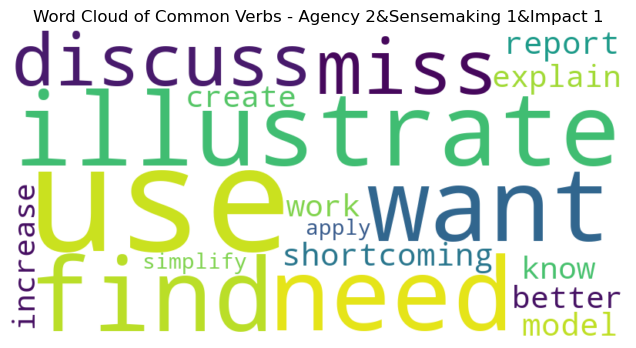

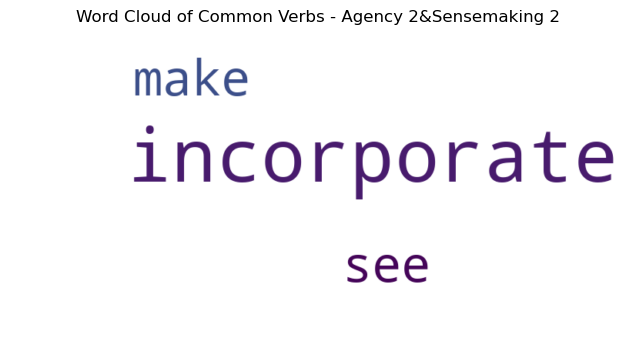

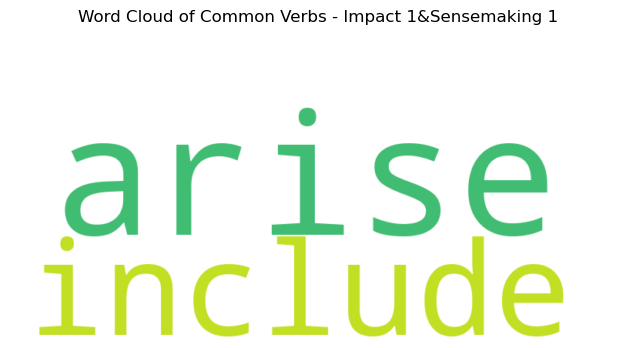

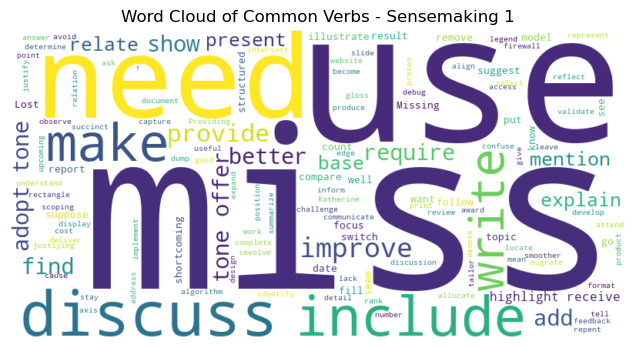

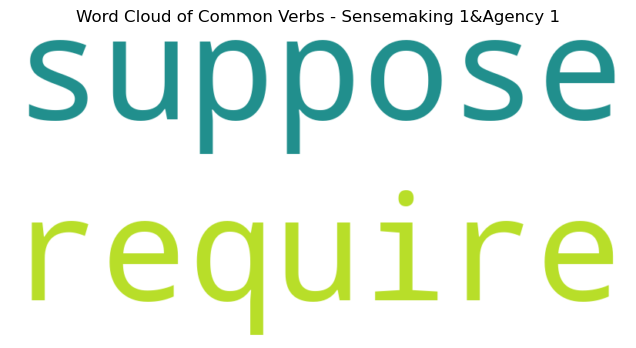

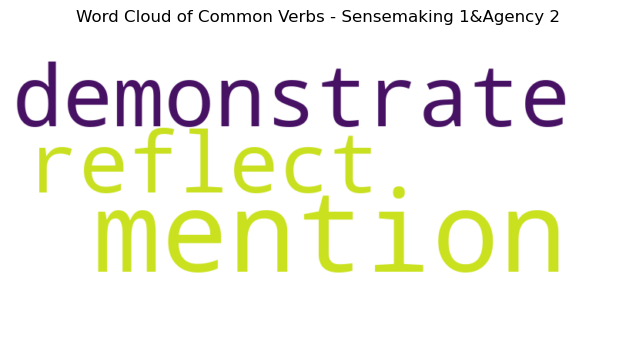

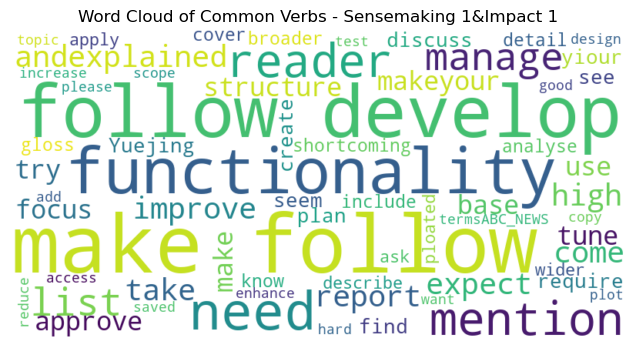

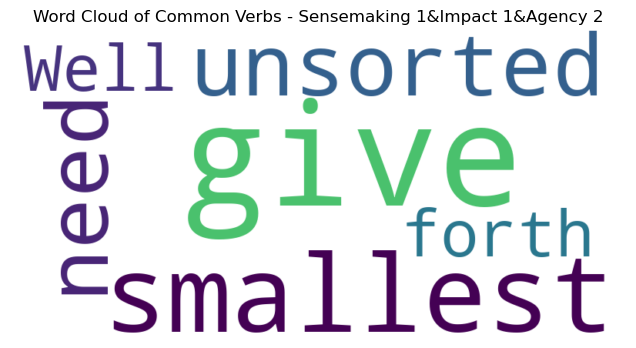

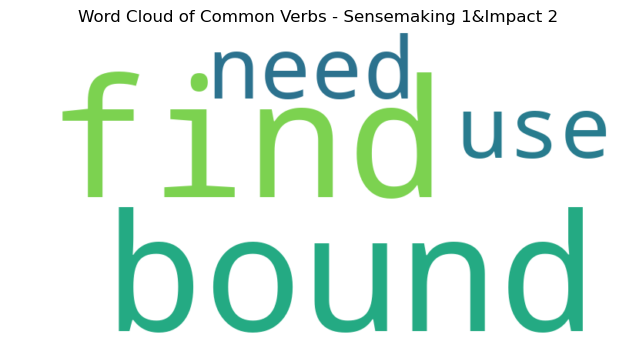

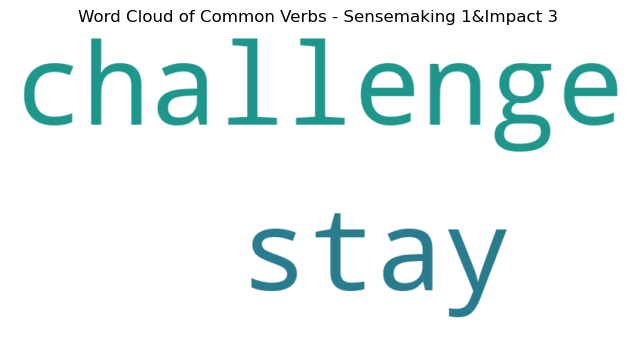

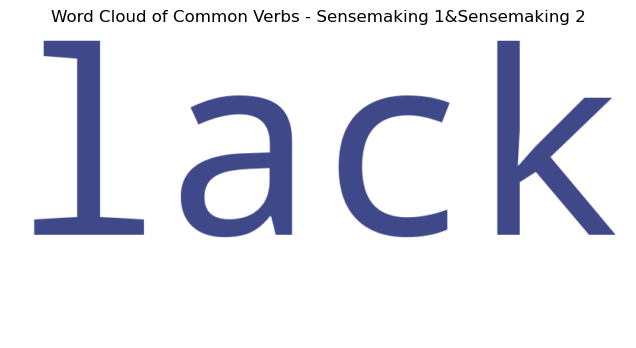

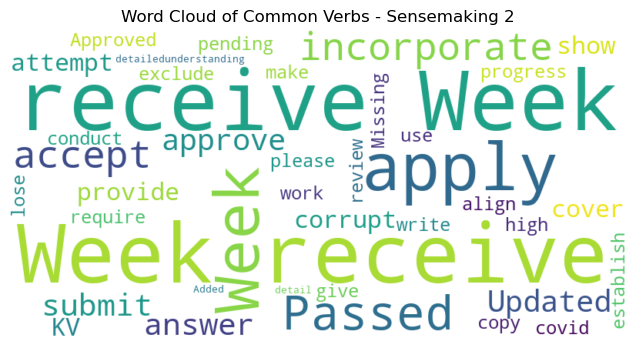

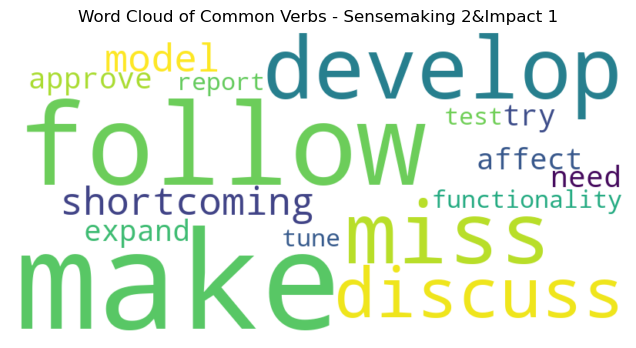

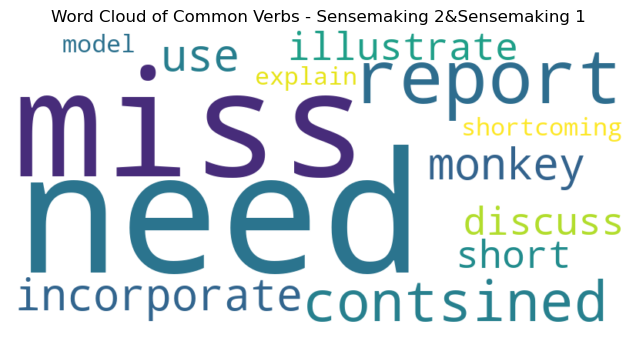

In [76]:
# Iterating over the groups and generate word clouds
for name, group in grouped_data:

    # Concatenating the verbs within the current group
    text = ' '.join([verb for sublist in group['Verbs'] for verb in sublist])

    # Performing an additional check to see if the list of verbs is empty
    if not text:
        print(f"No words found for group '{name}'. Skipping word cloud generation.")
        continue

    # Generating a word cloud for the group in the current iteration
    wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(text)

    # Displaying the word cloud for the group in the current iteration
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud of Common Verbs - {name}')
    plt.axis('off')
    plt.show()

We can see the different words represented beautifully in the different word clouds. The bigger the size of the word, the more prevalent it is for that rubric combination. However, in the next part, we will perform some in-depth analysis to understand the recurrance of words and phrases.

## Part 4: Recurring Words

To analyse the recurrence of words for the Sensemaking aspect, We will use `N-Grams`. `N-Grams` are specific sequences of words that may or may not hold some meaning. In natural language processing, it is often useful to observe the most frequent ngrams to discover patterns in the text.

As was the case in the rest of this notebook, we will produce Ngrams for different granularities of the labelled feedback data.

In this study, we are going to discover bigrams and trigrams in the feedback. `Bigrams` are two-word combinations and `Trigrams` are three-word combinations.

### 1 N-Grams

First, let us load the necessary library.

In [69]:
# Importing the count vectorizer from sklearn
from sklearn.feature_extraction.text import CountVectorizer

Since we are producing bigrams and trigrams, we need to specify this range for both of them.

In [70]:
# Defining the bigram range
ngram_range1 = (2, 2)

# Defining the trigram range
ngram_range2 = (3, 3)

#### 1.1 N-Grams for Multi-Rubric Combinations and Single Rubric Occurrences

Since bigrams and trigrams are word combinations, we need to tokenize the text first so that we have words as tokens. We also need to load the stop words and remove them from the text otherwise, they will be picked up by the ngram processor.

In [71]:
# Loading the stop words
stop_words = set(stopwords.words('english'))

##### 1.1.1 Bi-Grams for Multi-Rubric Combinations and Single Rubric Occurrences

First, we will produce the bigrams for the multi-rubric combinations and the non-rubric combination occurences of each rubric. We already have the data and so let us go ahead and tokenize the text in that data set.

In [72]:
# Tokenizing complete sentences and extracting the words
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
multi_rubric['TokenizedSentences'] = multi_rubric['Sentence'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])

# Checking the tokenized sentence
multi_rubric[['Rubric', 'TokenizedSentences']]

,Rubric,TokenizedSentences
0,Sensemaking 1 & Impact 1,"[yuejing, depth, analysis, required, see, link..."
1,Impact 1,"[﻿team, 1, requested, re-do, workbook, 3, bett..."
2,Sensemaking 2,"[team, submitted, workbook, 23, days, submissi..."
3,Sensemaking 1,"[risk, assessment, report, needs, work, discus..."
4,Agency 2 & Agency 1,"[``, good, effort, ,, please, refer, detailed,..."
...,...,...
5754,Impact 1,"[q2, :, 6.5/7, need, use, english, communicate..."
5755,Sensemaking 1,"[part, (, b, ), ,, complicated, needed, ,, exp..."
5756,Impact 2,"[q3, :, 11.5/13, :, english, exposition, requi..."
5757,Sensemaking 1,"[made, two, errors, :, finding, determinant, p..."


We need to rejoin the tokens so that the tokenized text can be passed as a string to the ngram processor.

In [73]:
# Combining the tokenized text into strings
multi_rubric['TokenizedText'] = multi_rubric['TokenizedSentences'].apply(lambda x: ' '.join(x))

# Checking the rejoined tokenized text
multi_rubric[['Rubric', 'TokenizedText']]

,Rubric,TokenizedText
0,Sensemaking 1 & Impact 1,yuejing depth analysis required see link key c...
1,Impact 1,﻿team 1 requested re-do workbook 3 better orig...
2,Sensemaking 2,team submitted workbook 23 days submission dat...
3,Sensemaking 1,risk assessment report needs work discussed tu...
4,Agency 2 & Agency 1,"`` good effort , please refer detailed feedbac..."
...,...,...
5754,Impact 1,"q2 : 6.5/7 need use english communicate , part..."
5755,Sensemaking 1,"part ( b ) , complicated needed , explain rate..."
5756,Impact 2,q3 : 11.5/13 : english exposition required .
5757,Sensemaking 1,made two errors : finding determinant part ( b...


To produce the ngrams, we need to vectorize the text with a count vectorizer. A `count vectorizer` converts text data into a meaningful and machine readable form. Before vectorizing it, we also need to remove the duplicates from the data.

In [74]:
# Removing the duplicate rows based on the tokenized text
multi_rubric = multi_rubric.drop_duplicates(subset='TokenizedText')

In [75]:
# Extracting the n-grams with the CountVectorizer function
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
vectorizer = CountVectorizer(ngram_range = ngram_range1)

# Fit transforming the data 
ngram_counts = vectorizer.fit_transform(multi_rubric['TokenizedText'])

Next, we can convert the vectorised bigram data to a dataframe.

In [76]:
# Creating a DataFrame to store the bigram frequencies
bigram_multi_rubric = pd.DataFrame(ngram_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Checking the new dataframe
bigram_multi_rubric

,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,10 15s,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The above data is not understandable and so let us add the multi-rubric  and non-combination rubric labels to the data and group them by each unique rubric column occurence.

In [77]:
# Adding the multi-rubric labels to the bigram dataframe
bigram_multi_rubric['Rubric'] = multi_rubric['Rubric']

In [78]:
# Grouping the n-gram frequencies by the rubric column
grouped_bigram_multi_rubric = bigram_multi_rubric.groupby('Rubric').sum().reset_index()

# Checking the grouped data
grouped_bigram_multi_rubric

,Rubric,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,Agency 1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Agency 1 & Impact 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agency 1 & Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agency 1 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agency 2,0,0,0,0,0,0,1,2,1,...,0,0,1,0,0,1,0,0,0,0
5,Agency 2 & Agency 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Agency 2 & Agency 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Agency 2 & Impact 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Agency 2 & Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Agency 2 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We have a massive dataset and so let us bring it into meaningful forms. First, let us filter the data to only include those combinations where a sensemaking rubric is involved.

In [79]:
# Filtering to the Sensemaking data
grouped_bigram_multi_rubric_sensemaking = grouped_bigram_multi_rubric[grouped_bigram_multi_rubric['Rubric'].str.contains('Sensemaking')]

# Filtering to the Rubric Combinations
grouped_bigram_multi_rubric_sensemaking = grouped_bigram_multi_rubric_sensemaking[grouped_bigram_multi_rubric_sensemaking['Rubric'].str.contains('&')].reset_index(drop = True)

# Checking the filtered data
grouped_bigram_multi_rubric_sensemaking

,Rubric,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,Agency 1 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agency 2 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agency 2 & Sensemaking 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Impact 1 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Impact 2 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Impact 3 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Sensemaking 1 & Agency 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Sensemaking 1 & Agency 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Sensemaking 1 & Impact 1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,Sensemaking 1 & Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, let us extract the top 10 bigrams for the filtered sensemaking multi-rubric data.

In [80]:
# Sorting the bi-gram frequencies in descending order and displaying the top 10
top_10_bigrams_multi_rubric = grouped_bigram_multi_rubric_sensemaking.set_index('Rubric').T
top_10_bigrams_multi_rubric['Total'] = top_10_bigrams_multi_rubric.sum(axis = 1)
top_10_bigrams_multi_rubric = top_10_bigrams_multi_rubric.sort_values(by = 'Total', ascending = False).head(10)

In [81]:
# Printing the top 10 n-grams
top_10_bigrams_multi_rubric

Rubric,Agency 1 & Sensemaking 1,Agency 2 & Sensemaking 1,Agency 2 & Sensemaking 2,Impact 1 & Sensemaking 1,Impact 2 & Sensemaking 1,Impact 3 & Sensemaking 1,Sensemaking 1 & Agency 1,Sensemaking 1 & Agency 2,Sensemaking 1 & Impact 1,Sensemaking 1 & Impact 2,Sensemaking 1 & Impact 3,Sensemaking 1 & Sensemaking 2,Sensemaking 2 & Agency 2,Sensemaking 2 & Impact 1,Sensemaking 2 & Impact 2,Sensemaking 2 & Sensemaking 1,Total
marks week,0,0,0,3,2,0,0,0,21,0,0,0,3,0,0,10,39
would better,0,0,0,0,0,0,0,0,6,0,0,0,0,0,1,1,8
well done,0,0,0,0,0,0,0,0,6,0,0,1,0,0,0,0,7
week 12,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,2,6
good work,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,5
ethical dimensions,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,5
ethical issues,0,0,0,0,0,0,0,0,2,0,0,3,0,0,0,0,5
good job,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,5
14 marks,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,5
br gt,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,0,5


Now, let us print the bigrams for occurences of rubrics outside of any rubric combination.

In [86]:
# Filtering to the Non multi-rubric occurences
grouped_bigram_non_multi_rubric = grouped_bigram_multi_rubric[~grouped_bigram_multi_rubric['Rubric'].str.contains('&')].reset_index(drop = True)

# Viewing the filtered data
grouped_bigram_non_multi_rubric

,Rubric,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,Agency 1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Agency 2,0,0,0,0,0,0,1,2,1,...,0,0,1,0,0,1,0,0,0,0
2,Agency 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Impact 1,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,1
4,Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Impact 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Sensemaking 1,1,1,0,1,1,1,1,12,3,...,0,1,0,0,0,0,1,1,2,1
7,Sensemaking 2,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0


In [87]:
# Sorting the bi-gram frequencies in descending order and displaying the top 10 bigrams
top_10_bigrams_non_multi_rubric = grouped_bigram_non_multi_rubric.set_index('Rubric').T
top_10_bigrams_non_multi_rubric['Total'] = top_10_bigrams_non_multi_rubric.sum(axis = 1)
top_10_bigrams_non_multi_rubric = top_10_bigrams_non_multi_rubric.sort_values(by = 'Total', ascending = False).head(10)

In [88]:
# Checking the single rubric bigram data
top_10_bigrams_non_multi_rubric

Rubric,Agency 1,Agency 2,Agency 3,Impact 1,Impact 2,Impact 3,Sensemaking 1,Sensemaking 2,Total
marks week,9,5,0,45,5,0,80,13,157
good job,6,2,0,13,0,0,17,2,40
well done,6,1,0,8,1,0,20,3,39
good work,2,0,0,11,1,0,18,3,35
make sure,0,2,1,11,2,1,17,1,35
discussion points,0,2,0,12,4,1,13,2,34
objective meeting,1,0,0,15,0,1,12,1,30
would better,3,2,0,7,0,1,13,1,27
could better,2,0,0,8,1,0,10,1,22
ways improve,0,0,0,9,0,0,11,1,21


##### 1.1.2 Tri-Grams for Multi-Rubric Combinations and Single Rubric Occurrences

We are going to follow the same set of steps to produce trigrams as was the case with the bigrams. However, we will use a new range in the vectorization process to extract three-word combinations.

In [89]:
# Extracting the tri-grams using CountVectorizer
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
vectorizer = CountVectorizer(ngram_range = ngram_range2)

# Performing a fit transform on the tokenized text
ngram_counts = vectorizer.fit_transform(multi_rubric['TokenizedText'])

In [90]:
# Creating a new dataframe to store the tri-gram frequencies
trigram_multi_rubric = pd.DataFrame(ngram_counts.toarray(), columns=vectorizer.get_feature_names_out())

# Checking the new dataframe
trigram_multi_rubric

,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,10 11 content,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3910,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3911,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3913,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
# Adding the rubric column to the tri-gram frequency data
trigram_multi_rubric['Rubric'] = multi_rubric['Rubric']

In [92]:
# Grouping the tri-gram frequencies by rubric
grouped_trigram_multi_rubric = trigram_multi_rubric.groupby('Rubric').sum().reset_index()

# Checking the grouped data
grouped_trigram_multi_rubric

,Rubric,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,Agency 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agency 1 & Impact 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agency 1 & Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agency 1 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agency 2,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
5,Agency 2 & Agency 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Agency 2 & Agency 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Agency 2 & Impact 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Agency 2 & Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Agency 2 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us filter the grouped trigram data to include only the sensemaking rubric combinations.

In [93]:
# Filtering the grouped trigram data by sensemaking
grouped_trigram_multi_rubric_sensemaking = grouped_trigram_multi_rubric[grouped_trigram_multi_rubric['Rubric'].str.contains('Sensemaking')]

# Filtering the grouped trigram data to only show the rubric combinations
grouped_trigram_multi_rubric_sensemaking = grouped_trigram_multi_rubric_sensemaking[grouped_trigram_multi_rubric_sensemaking['Rubric'].str.contains('&')].reset_index(drop = True)

# Checking the filtered data
grouped_trigram_multi_rubric_sensemaking

,Rubric,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,Agency 1 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agency 2 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agency 2 & Sensemaking 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Impact 1 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Impact 2 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Impact 3 & Sensemaking 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Sensemaking 1 & Agency 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Sensemaking 1 & Agency 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Sensemaking 1 & Impact 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Sensemaking 1 & Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let us sort the trigram frequencies in descending order and show the top ten trigrams.

In [94]:
# Sorting the tri-gram frequencies in descending order and displaying the top ten trigrams
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
top_10_trigrams_multi_rubric = grouped_trigram_multi_rubric_sensemaking.set_index('Rubric').T
top_10_trigrams_multi_rubric['Total'] = top_10_trigrams_multi_rubric.sum(axis = 1)
top_10_trigrams_multi_rubric = top_10_trigrams_multi_rubric.sort_values(by = 'Total', ascending = False).head(10)

In [95]:
# Checking the data that contains the top ten trigrams
top_10_trigrams_multi_rubric

Rubric,Agency 1 & Sensemaking 1,Agency 2 & Sensemaking 1,Agency 2 & Sensemaking 2,Impact 1 & Sensemaking 1,Impact 2 & Sensemaking 1,Impact 3 & Sensemaking 1,Sensemaking 1 & Agency 1,Sensemaking 1 & Agency 2,Sensemaking 1 & Impact 1,Sensemaking 1 & Impact 2,Sensemaking 1 & Impact 3,Sensemaking 1 & Sensemaking 2,Sensemaking 2 & Agency 2,Sensemaking 2 & Impact 1,Sensemaking 2 & Impact 2,Sensemaking 2 & Sensemaking 1,Total
marks week 14,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,5
part notebook good,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,5
14 marks week,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,5
lt br gt,0,0,0,2,0,0,0,0,3,0,0,0,0,0,0,0,5
marks week 12,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,2,5
15 marks week,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,5
17 marks week,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,5
week 14 marks,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,5
16 marks week,0,0,0,0,0,0,0,0,2,0,0,0,2,0,0,1,5
model evaluation inference,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,4


We can now view the trigrams for the singular occurences of rubrics outside of any combination.

In [97]:
# Filtering the data to only include individual rubric occurences
grouped_trigram_non_multi_rubric = grouped_trigram_multi_rubric[~grouped_trigram_multi_rubric['Rubric'].str.contains('&')].reset_index(drop = True)

# Displaying the filtered data
grouped_trigram_non_multi_rubric

,Rubric,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,Agency 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agency 2,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
2,Agency 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Impact 1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Impact 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Sensemaking 1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,1,2,0,1
7,Sensemaking 2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Let us produce the top ten trigrams for the non-rubric combination data.

In [98]:
# Sorting the tri-gram frequencies in descending order and displaying the top 10 trigrams
top_10_trigrams_non_multi_rubric = grouped_trigram_non_multi_rubric.set_index('Rubric').T
top_10_trigrams_non_multi_rubric['Total'] = top_10_trigrams_non_multi_rubric.sum(axis = 1)
top_10_trigrams_non_multi_rubric = top_10_trigrams_non_multi_rubric.sort_values(by = 'Total', ascending = False).head(10)

In [99]:
# Displaying the trigrams for the non multi-rubric occurences
top_10_trigrams_non_multi_rubric

Rubric,Agency 1,Agency 2,Agency 3,Impact 1,Impact 2,Impact 3,Sensemaking 1,Sensemaking 2,Total
16 marks week,1,0,0,5,1,0,12,2,21
17 marks week,1,0,0,6,1,0,12,0,20
please make sure,0,0,1,6,1,0,9,0,17
11 marks week,1,1,0,3,0,0,9,2,16
model evaluation inference,1,0,0,1,2,0,11,1,16
marks week 12,0,2,0,3,0,0,10,1,16
marks week 10,1,1,0,4,0,0,10,0,16
week 10 11,0,2,0,2,0,0,10,0,14
date time location,0,1,0,3,2,1,6,1,14
18 marks week,1,0,0,7,0,0,5,1,14


#### 1.2 N-Grams for Total Rubric Occurences

The following code will follow the same pattern for producing the bigrams and trigrams for the total individual rubric occurences.

##### 1.2.1 Bigrams for Total Rubric Occurences

Since bigrams and trigrams are word combinations, we need to tokenize the text first so that we have words as tokens. We also need to load the stop words and remove them from the text otherwise, they will be picked up by the ngram processor.

In [95]:
# Tokenizing the sentences and removing the stop words from the total rubric occurence data
data_rubric['TokenizedSentences'] = data_rubric['Sentence'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])

# Checking the tokenized data
data_rubric[['Rubric', 'TokenizedSentences']]

,Rubric,TokenizedSentences
0,Sensemaking 1,"[yuejing, depth, analysis, required, see, link..."
0,Impact 1,"[yuejing, depth, analysis, required, see, link..."
1,Impact 1,"[﻿team, 1, requested, re-do, workbook, 3, bett..."
2,Sensemaking 2,"[team, submitted, workbook, 23, days, submissi..."
3,Sensemaking 1,"[risk, assessment, report, needs, work, discus..."
...,...,...
5754,Impact 1,"[q2, :, 6.5/7, need, use, english, communicate..."
5755,Sensemaking 1,"[part, (, b, ), ,, complicated, needed, ,, exp..."
5756,Impact 2,"[q3, :, 11.5/13, :, english, exposition, requi..."
5757,Sensemaking 1,"[made, two, errors, :, finding, determinant, p..."


In [96]:
# Combining the tokenized sentences into strings
data_rubric['TokenizedText'] = data_rubric['TokenizedSentences'].apply(lambda x: ' '.join(x))

# Checking the joined token text
data_rubric[['Rubric', 'TokenizedText']]

,Rubric,TokenizedText
0,Sensemaking 1,yuejing depth analysis required see link key c...
0,Impact 1,yuejing depth analysis required see link key c...
1,Impact 1,﻿team 1 requested re-do workbook 3 better orig...
2,Sensemaking 2,team submitted workbook 23 days submission dat...
3,Sensemaking 1,risk assessment report needs work discussed tu...
...,...,...
5754,Impact 1,"q2 : 6.5/7 need use english communicate , part..."
5755,Sensemaking 1,"part ( b ) , complicated needed , explain rate..."
5756,Impact 2,q3 : 11.5/13 : english exposition required .
5757,Sensemaking 1,made two errors : finding determinant part ( b...


In [97]:
# Removing the duplicate rows based on the 'tokenized text
data_rubric = data_rubric.drop_duplicates(subset = 'TokenizedText')

In [98]:
# Extracting the bi-grams using the CountVectorizer
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
vectorizer = CountVectorizer(ngram_range = ngram_range1)

# Applying the fit transform to the tokenized text
ngram_counts = vectorizer.fit_transform(data_rubric['TokenizedText'])

In [99]:
# Creating a new dataframe to store the bigram frequencies
bigrams_rubric = pd.DataFrame(ngram_counts.toarray(), columns=vectorizer.get_feature_names_out())

In [100]:
# Adding the rubric column to the bigram data
bigrams_rubric['Rubric'] = data_rubric['Rubric']

In [101]:
# Grouping the bi-gram frequencies by the 'Rubric' column
grouped_bigrams_rubric = bigrams_rubric.groupby('Rubric').sum().reset_index()

# Checking the grouped data
grouped_bigrams_rubric

,Rubric,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,Agency 1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Agency 2,0,0,0,0,0,0,1,2,1,...,0,0,1,0,0,1,0,0,0,0
2,Agency 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,Impact 1,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,1
4,Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Impact 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Sensemaking 1,1,1,0,1,1,1,1,13,3,...,0,1,0,0,0,0,1,1,2,1
7,Sensemaking 2,0,0,0,0,0,0,0,3,2,...,1,0,0,0,0,0,0,0,0,0


In [102]:
# Filtering the data to only view the sensemaking rubrics
grouped_bigrams_rubric_sensemaking = grouped_bigrams_rubric[grouped_bigrams_rubric['Rubric'].str.contains('Sensemaking')].reset_index(drop = True)

# Checking the filtered data
grouped_bigrams_rubric_sensemaking

,Rubric,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,Sensemaking 1,1,1,0,1,1,1,1,13,3,...,0,1,0,0,0,0,1,1,2,1
1,Sensemaking 2,0,0,0,0,0,0,0,3,2,...,1,0,0,0,0,0,0,0,0,0


In [103]:
# Sorting the bi-gram frequencies in descending order and showing the top 10 bigrams for the total rubric data
top_10_bigrams_rubric = grouped_bigrams_rubric_sensemaking.set_index('Rubric').T
top_10_bigrams_rubric['Total'] = top_10_bigrams_rubric.sum(axis=1)
top_10_bigrams_rubric = top_10_bigrams_rubric.sort_values(by = 'Total', ascending = False).head(10)

In [104]:
# Viewing the top 10 bi-grams for the total rubric data
top_10_bigrams_rubric

Rubric,Sensemaking 1,Sensemaking 2,Total
marks week,101,26,127
well done,27,3,30
good work,23,3,26
good job,22,2,24
make sure,19,3,22
would better,19,3,22
model evaluation,17,2,19
16 marks,14,5,19
week 12,15,3,18
ethical issues,11,6,17


##### 1.2.2 Tri-Grams for Total Rubrics Occurences

In this section, we will tackle the generation of trigrams for the total rubric occurences. Remmeber that the total rubric occurences are individual occurences of each rubric that are inclusive of the multi-rubric data and the unique non multi-rubric data. We will follow the same steps that were followed for generating the trigrams for the multi-rubric data. 

In [105]:
# Extracting the tri-grams using for the total rubric data using the CountVectorizer
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
vectorizer = CountVectorizer(ngram_range = ngram_range2)

# Applying a fit transform on the tokenized text
ngram_counts = vectorizer.fit_transform(data_rubric['TokenizedText'])

In [106]:
# Creating a new dataframe to store the tri-gram frequencies
trigrams_rubric = pd.DataFrame(ngram_counts.toarray(), columns=vectorizer.get_feature_names_out())

In [107]:
# Adding the rubric column to the trigram frequency data
trigrams_rubric['Rubric'] = data_rubric['Rubric']

In [108]:
# Grouping the tri-gram frequencies by the rubric column
grouped_trigrams_rubric = trigrams_rubric.groupby('Rubric').sum().reset_index()

# Checking the grouped data
grouped_trigrams_rubric

,Rubric,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,Agency 1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agency 2,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
2,Agency 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Impact 1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,Impact 2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Impact 3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Sensemaking 1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,1,2,0,1
7,Sensemaking 2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [109]:
# Filtering the grouped data to show only the sensemaking rubrics
grouped_trigrams_rubric_sensemaking = grouped_trigrams_rubric[grouped_trigrams_rubric['Rubric'].str.contains('Sensemaking')].reset_index(drop = True)

# Checking the filtered data
grouped_trigrams_rubric_sensemaking

,Rubric,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,Sensemaking 1,0,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,1,2,0,1
1,Sensemaking 2,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [110]:
# Sorting the tri-gram frequencies in descending order and showing the top 10 trigrams
top_10_trigrams_rubric = grouped_trigrams_rubric_sensemaking.set_index('Rubric').T
top_10_trigrams_rubric['Total'] = top_10_trigrams_rubric.sum(axis=1)
top_10_trigrams_rubric = top_10_trigrams_rubric.sort_values(by = 'Total', ascending = False).head(10)

In [111]:
# Printing the data that contains the top 10 trigrams for the total rubric data
top_10_trigrams_rubric

Rubric,Sensemaking 1,Sensemaking 2,Total
16 marks week,14,5,19
17 marks week,16,0,16
model evaluation inference,15,1,16
marks week 12,12,3,15
11 marks week,10,4,14
15 marks week,10,4,14
14 marks week,9,4,13
marks week 10,11,2,13
week 10 11,11,2,13
lt br gt,10,2,12


#### 1.3 N-Grams for Components

As was the case in the rest of this notebook, we will produce the top ten bigrams and trigrams for the component level data. Remember that the three components are Sensemaking, Impact and Agency. The component level data includes every occurence of every rubric that belongs to that component.

##### 1.3.1 Bi-Grams for Components

To produce the bigrams for each component, we will follow the same set of steps that was followed for producing the bigrams for the multi-rubric and total rubric data starting with the tokenization of the text and removal of stop words.

In [112]:
# Tokenizing the sentences and removing the stop words
data_component['TokenizedSentences'] = data_component['Sentence'].apply(lambda x: [word.lower() for word in word_tokenize(x) if word.lower() not in stop_words])

# Checking the tokenized data
data_component[['Component', 'TokenizedSentences']]

,Component,TokenizedSentences
0,Sensemaking,"[yuejing, depth, analysis, required, see, link..."
0,Impact,"[yuejing, depth, analysis, required, see, link..."
1,Impact,"[﻿team, 1, requested, re-do, workbook, 3, bett..."
2,Sensemaking,"[team, submitted, workbook, 23, days, submissi..."
3,Sensemaking,"[risk, assessment, report, needs, work, discus..."
...,...,...
5754,Impact,"[q2, :, 6.5/7, need, use, english, communicate..."
5755,Sensemaking,"[part, (, b, ), ,, complicated, needed, ,, exp..."
5756,Impact,"[q3, :, 11.5/13, :, english, exposition, requi..."
5757,Sensemaking,"[made, two, errors, :, finding, determinant, p..."


In [113]:
# Combining the tokenized sentences into strings
data_component['TokenizedText'] = data_component['TokenizedSentences'].apply(lambda x: ' '.join(x))

# Checking the joined tokens
data_component[['Component', 'TokenizedText']]

,Component,TokenizedText
0,Sensemaking,yuejing depth analysis required see link key c...
0,Impact,yuejing depth analysis required see link key c...
1,Impact,﻿team 1 requested re-do workbook 3 better orig...
2,Sensemaking,team submitted workbook 23 days submission dat...
3,Sensemaking,risk assessment report needs work discussed tu...
...,...,...
5754,Impact,"q2 : 6.5/7 need use english communicate , part..."
5755,Sensemaking,"part ( b ) , complicated needed , explain rate..."
5756,Impact,q3 : 11.5/13 : english exposition required .
5757,Sensemaking,made two errors : finding determinant part ( b...


In [114]:
# Removing the duplicate rows based on the tokenized text
data_component = data_component.drop_duplicates(subset = 'TokenizedText')

In [115]:
# Extracting the bi-grams for the components using the CountVectorizer
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
vectorizer = CountVectorizer(ngram_range = ngram_range1)

# Applying the fit transform on the tokenized text
ngram_counts = vectorizer.fit_transform(data_component['TokenizedText'])

In [116]:
# Creating a new dataframe to store the bi-gram frequencies for the components
bigrams_component = pd.DataFrame(ngram_counts.toarray(), columns=vectorizer.get_feature_names_out())

In [117]:
# Adding the Component column to the bi-gram frequency data
bigrams_component['Component'] = data_component['Component']

In [118]:
# Grouping the bi-gram frequencies by the 'Rubric' column
grouped_bigrams_component = bigrams_component.groupby('Component').sum().reset_index()

# Checking the grouped data
grouped_bigrams_component

,Component,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,Agency,0,0,0,0,0,0,1,2,2,...,0,0,1,0,0,1,1,0,0,0
1,Impact,0,0,0,0,0,0,0,2,1,...,0,0,0,0,0,0,0,0,0,1
2,Sensemaking,1,1,0,1,1,1,1,16,5,...,1,1,0,0,0,0,1,1,2,1


In [119]:
# Filtering the data to only view the Sensemaking bigrams
grouped_bigrams_component_sensemaking = grouped_bigrams_component[grouped_bigrams_component['Component'].str.contains('Sensemaking')].reset_index(drop = True)

# Checking the filterd data
grouped_bigrams_component_sensemaking

,Component,00 00,00 24,00 34,00 50,06 please,0else return,0your final,10 11,10 15,...,yyyy format,zero sextillion,zeshan business,zhengyang write,zhou unfortunately,zixi br,zone differences,zones workflow,zoom features,zoom meeting
0,Sensemaking,1,1,0,1,1,1,1,16,5,...,1,1,0,0,0,0,1,1,2,1


In [120]:
# Sorting the bi-gram frequencies in descending order and showing the top 10 ngrams
top_10_bigrams_component = grouped_bigrams_component_sensemaking.set_index('Component').T
top_10_bigrams_component['Total'] = top_10_bigrams_component.sum(axis=1)
top_10_bigrams_component = top_10_bigrams_component.sort_values(by = 'Total', ascending = False).head(10)

In [121]:
# Printing the data that contains the top ten bi-grams for each component
top_10_bigrams_component

Component,Sensemaking,Total
marks week,127,127
well done,30,30
good work,26,26
good job,24,24
make sure,22,22
would better,22,22
model evaluation,19,19
16 marks,19,19
week 12,18,18
ethical issues,17,17


##### 1.3.2 Tri-Grams for Components

We will use the specified range for producing trigrams for the component level data. The steps to be followed are the same as the ones executed for generating the trigrams for the multi-rubric and total rubric data.

In [122]:
# Extracting the Tri-grams for the three components using CountVectorizer
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
vectorizer = CountVectorizer(ngram_range = ngram_range2)

# Applying the fit trasnform to the tokenized component level data
ngram_counts = vectorizer.fit_transform(data_component['TokenizedText'])

In [123]:
# Creating a new dataframe to store the Tri-gram frequencies for each component
trigrams_component = pd.DataFrame(ngram_counts.toarray(), columns=vectorizer.get_feature_names_out())

In [124]:
# Adding the component column to the trigram data
trigrams_component['Component'] = data_component['Component']

In [125]:
# Grouping the Tri-gram frequencies by the Components
grouped_trigrams_component = trigrams_component.groupby('Component').sum().reset_index()

# Checking the grouped data
grouped_trigrams_component

,Component,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,Agency,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0
1,Impact,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,Sensemaking,0,1,0,1,1,1,0,1,1,...,0,1,0,0,0,0,1,2,0,1


In [126]:
# Filtering the data to show the trigram frequencies for the Sensemaking component
grouped_trigrams_component_sensemaking = grouped_trigrams_component[grouped_trigrams_component['Component'].str.contains('Sensemaking')].reset_index(drop = True)

# Checking the filtered data
grouped_trigrams_component_sensemaking

,Component,00 00 00,00 00 24,00 00 34,00 24 59,06 please modify,0else return ten,0your final mark,0your final output,10 11 10,...,yutong ve done,yyyy format using,zeshan business report,zhengyang write really,zhou unfortunately business,zixi br hasclear,zones workflow speed,zoom features teaching,zoom meeting agenda,zoom meeting specified
0,Sensemaking,0,1,0,1,1,1,0,1,1,...,0,1,0,0,0,0,1,2,0,1


In [127]:
# Sorting the tri-gram frequencies in descending order and showing the top 10 trigrams for the sensemaking component
top_10_trigrams_component = grouped_trigrams_component_sensemaking.set_index('Component').T
top_10_trigrams_component['Total'] = top_10_trigrams_component.sum(axis=1)
top_10_trigrams_component = top_10_trigrams_component.sort_values(by = 'Total', ascending = False).head(10)

In [128]:
# Printing the data that contains the top ten trigrams for Sensemaking
top_10_trigrams_component

Component,Sensemaking,Total
16 marks week,19,19
17 marks week,16,16
model evaluation inference,16,16
marks week 12,15,15
11 marks week,14,14
15 marks week,14,14
14 marks week,13,13
marks week 10,13,13
week 10 11,13,13
lt br gt,12,12


### 2. Most Frequent Word

In the previous section, we extracted bigrams and trigrams from the data. Let us focus on the unigrams now. We need to observe the most frequent single-word occurences at different granularities.

#### 2.1 Most Frequent Word - Multi-Rubric Combinations and Single Rubric Occurrences

First, we will extract the most frequent words for each unique multi-rubric combination and single rubric occurences. As was the case with the bigrams and the trigrams, let us create a user-defined function to tokenize the text and remove the stop words.

In [100]:
# Defining a function to preprocess the text and extract words
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
def text_preprocessor(text):
    
    # Converting the characters of the text to lowercase form
    text = text.lower()
    
    # Removing all punctuations from the text
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Tokenizing the text
    tokens = word_tokenize(text)
    
    # Loading the stop words
    stop_words = set(stopwords.words('english'))
    
    # Removing the stopwords from the tokenized text
    filtered_words = [word for word in tokens if word not in stop_words]
    
    # Joining the filtered words
    filtered_text = ' '.join(filtered_words)
    
    # Returning the filtered text
    return filtered_text

Let us apply the above preprocessing function to the raw feedback text.

In [101]:
# Apply text preprocessing and extract the 10 most common words for each rubric
common_words_by_multi_rubric = multi_rubric.groupby('Rubric')['Sentence'].apply(lambda x: Counter(' '.join(text_preprocessor(sentence) for sentence in x).split()).most_common(10))

Now, we will create a new dataframe that extracts the most common words for all the unique rubrics and rubric combinations

In [102]:
# Creating a dataframe from the extracted common words
common_words_multi_rubric = pd.DataFrame([(rubric, word, count) for rubric, words in common_words_by_multi_rubric.items() for word, count in words],
                               columns=['Rubric', 'Word', 'Count'])

# Checking the new dataframe
common_words_multi_rubric

,Rubric,Word,Count
0,Agency 1,week,252
1,Agency 1,marks,249
2,Agency 1,received,97
3,Agency 1,6,33
4,Agency 1,8,32
...,...,...,...
412,Sensemaking 2 & Sensemaking 1 & Impact 1,part,5
413,Sensemaking 2 & Sensemaking 1 & Impact 1,1,5
414,Sensemaking 2 & Sensemaking 1 & Impact 1,better,5
415,Sensemaking 2 & Sensemaking 1 & Impact 1,notebook,5


The above data is messy and does not make much sense. So, let us sort the counts and display the data in a meaningful way. First, let us sort the word frequency in descending order for each unique rubric combination and single rubric occurence.

In [103]:
# Sort the DataFrame by Rubric first and then by Count in descending order
common_words_multi_rubric = common_words_multi_rubric.sort_values(by = ['Rubric', 'Count'], ascending=[True, False]).reset_index(drop = True)

# Checking the dataframe
common_words_multi_rubric

,Rubric,Word,Count
0,Agency 1,week,252
1,Agency 1,marks,249
2,Agency 1,received,97
3,Agency 1,6,33
4,Agency 1,8,32
...,...,...,...
412,Sensemaking 2 & Sensemaking 1 & Impact 1,part,5
413,Sensemaking 2 & Sensemaking 1 & Impact 1,1,5
414,Sensemaking 2 & Sensemaking 1 & Impact 1,better,5
415,Sensemaking 2 & Sensemaking 1 & Impact 1,notebook,5


Since we are concerned with the sensemaking aspect, we can first filter the data to show the rubric combinations that have at least one sensemaking rubric.

In [104]:
# Filtering the DataFrame to include only those rows that have the sensemaking component
common_words_multi_rubric_sensemaking = common_words_multi_rubric[common_words_multi_rubric['Rubric'].str.contains('Sensemaking')]

# Filtering out the single rubric occurences
common_words_multi_rubric_sensemaking = common_words_multi_rubric_sensemaking[common_words_multi_rubric_sensemaking['Rubric'].str.contains('&')].reset_index(drop = True)

In [105]:
# Checking the filtered data
common_words_multi_rubric_sensemaking

,Rubric,Word,Count
0,Agency 1 & Sensemaking 1,make,2
1,Agency 1 & Sensemaking 1,sure,2
2,Agency 1 & Sensemaking 1,aeration,2
3,Agency 1 & Sensemaking 1,lastly,1
4,Agency 1 & Sensemaking 1,recommend,1
...,...,...,...
203,Sensemaking 2 & Sensemaking 1 & Impact 1,part,5
204,Sensemaking 2 & Sensemaking 1 & Impact 1,1,5
205,Sensemaking 2 & Sensemaking 1 & Impact 1,better,5
206,Sensemaking 2 & Sensemaking 1 & Impact 1,notebook,5


Let us sort the filtered rows in descending order.

In [106]:
# Sorting by count and displaying the top 10 words and their respective rubric combinations
common_words_multi_rubric_sensemaking.sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Rubric,Word,Count
0,Sensemaking 1 & Impact 1,could,87
1,Sensemaking 1 & Impact 1,questions,74
2,Sensemaking 1 & Impact 1,would,64
3,Sensemaking 1 & Impact 1,better,64
4,Sensemaking 1 & Impact 1,good,58
5,Sensemaking 1 & Impact 1,meeting,56
6,Sensemaking 1 & Impact 1,code,49
7,Sensemaking 1 & Impact 1,example,46
8,Sensemaking 1 & Impact 1,also,44
9,Sensemaking 1 & Impact 1,issues,44


We can see that the top ten most frequent words occur with the rubric combination Sensemaking 1 & Impact 1. Now let us group the data such that we see the most frequent word for every unique Sensemaking rubric combination.

In [107]:
# Grouping the data by the most frequent word in each rubric combination
common_words_multi_rubric_sensemaking.groupby(['Rubric'], as_index=False).max().sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Rubric,Word,Count
0,Sensemaking 1 & Impact 1,would,87
1,Sensemaking 2 & Sensemaking 1,well,24
2,Agency 2 & Sensemaking 1,try,17
3,Agency 2 & Sensemaking 1 & Impact 1,using,12
4,Sensemaking 2 & Impact 1,work,10
5,Agency 2 & Sensemaking 2,well,9
6,Sensemaking 1 & Agency 2,work,7
7,Sensemaking 2 & Sensemaking 1 & Impact 1,using,7
8,Impact 1 & Sensemaking 1,times,7
9,Sensemaking 1 & Impact 1 & Agency 2,us,5


Let us discover the most frequent word for the instances of rubrics outside of being a part of any rubric combination.

In [108]:
#Filtering the DataFrame to include only non multi-rubric rows
common_words_non_multi_rubric = common_words_multi_rubric[~common_words_multi_rubric['Rubric'].str.contains('&')].reset_index(drop = True)

In [110]:
# Checking the filtered data
common_words_non_multi_rubric

,Rubric,Word,Count
0,Agency 1,week,252
1,Agency 1,marks,249
2,Agency 1,received,97
3,Agency 1,6,33
4,Agency 1,8,32
...,...,...,...
75,Sensemaking 2,penalty,22
76,Sensemaking 2,applied,21
77,Sensemaking 2,questions,20
78,Sensemaking 2,overall,18


In [111]:
# Sorting by count and displaying the top 10 words and their respective rubric
common_words_non_multi_rubric.sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Rubric,Word,Count
0,Agency 1,week,252
1,Agency 1,marks,249
2,Sensemaking 1,good,199
3,Sensemaking 1,could,179
4,Impact 1,could,163
5,Sensemaking 1,also,161
6,Sensemaking 1,well,133
7,Impact 1,meeting,132
8,Impact 1,need,126
9,Sensemaking 1,clear,117


In [112]:
# Printing the most common word for each non multi-rubric occurence
common_words_non_multi_rubric.groupby(['Rubric'], as_index=False).max().sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Rubric,Word,Count
0,Agency 1,week,252
1,Sensemaking 1,well,199
2,Impact 1,points,163
3,Sensemaking 2,well,83
4,Agency 2,work,78
5,Agency 3,thanks,14
6,Impact 2,understand,14
7,Impact 3,written,13


#### 2.2 Most Frequent Word - Total Rubric Occurences

In this section, we will follow the same set of steps to extract the most common words but this time for the total occurences of every rubric irrespective of whether they occur by themselves or as a part of a rubric combination.

In [137]:
# Applying the preprocessing and extracting the 10 most common words for each rubric
common_words_by_rubric = data_rubric.groupby('Rubric')['Sentence'].apply(lambda x: Counter(' '.join(text_preprocessor(sentence) for sentence in x).split()).most_common(10))

In [138]:
# Creating a new dataframe containing the common words
common_words_rubric = pd.DataFrame([(rubric, word, count) for rubric, words in common_words_by_rubric.items() for word, count in words],
                               columns=['Rubric', 'Word', 'Count'])

# Checking the dataframe
common_words_rubric

,Rubric,Word,Count
0,Agency 1,week,252
1,Agency 1,marks,249
2,Agency 1,received,97
3,Agency 1,6,33
4,Agency 1,8,32
...,...,...,...
75,Sensemaking 2,overall,31
76,Sensemaking 2,questions,28
77,Sensemaking 2,received,28
78,Sensemaking 2,late,28


In [139]:
# Sorting the data by Rubric and Count in descending order
common_words_rubric = common_words_rubric.sort_values(by = ['Rubric', 'Count'], ascending=[True, False]).reset_index(drop = True)

# Checking the dataframe
common_words_rubric

,Rubric,Word,Count
0,Agency 1,week,252
1,Agency 1,marks,249
2,Agency 1,received,97
3,Agency 1,6,33
4,Agency 1,8,32
...,...,...,...
75,Sensemaking 2,overall,31
76,Sensemaking 2,questions,28
77,Sensemaking 2,received,28
78,Sensemaking 2,late,28


In [140]:
#Filtering the DataFrame to include only the sensemaking rubrics
common_words_rubric_sensemaking = common_words_rubric[common_words_rubric['Rubric'].str.contains('Sensemaking')].reset_index(drop = True)


In [141]:
# Checking the filtered data
common_words_rubric_sensemaking

,Rubric,Word,Count
0,Sensemaking 1,could,268
1,Sensemaking 1,good,267
2,Sensemaking 1,also,208
3,Sensemaking 1,questions,187
4,Sensemaking 1,question,153
5,Sensemaking 1,well,151
6,Sensemaking 1,clear,150
7,Sensemaking 1,better,143
8,Sensemaking 1,however,134
9,Sensemaking 1,would,130


In [142]:
# Sorting by count and displaying the top 10 words and their respective rubrics
common_words_rubric_sensemaking.sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Rubric,Word,Count
0,Sensemaking 1,could,268
1,Sensemaking 1,good,267
2,Sensemaking 1,also,208
3,Sensemaking 1,questions,187
4,Sensemaking 1,question,153
5,Sensemaking 1,well,151
6,Sensemaking 1,clear,150
7,Sensemaking 1,better,143
8,Sensemaking 1,however,134
9,Sensemaking 1,would,130


On observing the above result, it is clear that the top most frequent words for the total rubric occurences belong to the Sensemaking 1 rubric. Let us view the most frequent word for the Sensemaking 1 and Sensemaking 2 rubrics.

In [143]:
# Showing the most common word for each sensemaking rubric
common_words_rubric_sensemaking.groupby(['Rubric'], as_index=False).max().sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Rubric,Word,Count
0,Sensemaking 1,would,268
1,Sensemaking 2,well,86


#### 2.3 Most Frequent Word - Components

Finally, we will change the granularity to a component level granularity and find the most frequent word for every component. The steps to extract these words is the same as the ones executed for the rubric level data.

In [144]:
# Applying the preprocessing and extracting the 10 most common words for each component
common_words_by_component = data_component.groupby('Component')['Sentence'].apply(lambda x: Counter(' '.join(text_preprocessor(sentence) for sentence in x).split()).most_common(10))

In [145]:
# Creating a new dataframe containing the common words
common_words_component = pd.DataFrame([(component, word, count) for component, words in common_words_by_component.items() for word, count in words],
                               columns=['Component', 'Word', 'Count'])

# Checking the dataframe
common_words_component

,Component,Word,Count
0,Agency,week,257
1,Agency,marks,251
2,Agency,good,121
3,Agency,received,97
4,Agency,work,71
5,Agency,done,71
6,Agency,well,55
7,Agency,job,48
8,Agency,1,43
9,Agency,however,38


In [146]:
# Sorting the data by Component and Count in descending order
common_words_component = common_words_component.sort_values(by = ['Component', 'Count'], ascending=[True, False]).reset_index(drop = True)

# Checking the dataframe
common_words_component

,Component,Word,Count
0,Agency,week,257
1,Agency,marks,251
2,Agency,good,121
3,Agency,received,97
4,Agency,work,71
5,Agency,done,71
6,Agency,well,55
7,Agency,job,48
8,Agency,1,43
9,Agency,however,38


In [147]:
#Filtering the DataFrame to include only those combinations that have the sensemaking component
common_words_component_sensemaking = common_words_component[common_words_component['Component'].str.contains('Sensemaking')].reset_index(drop = True)


In [148]:
# Checking the filtered data
common_words_component_sensemaking

,Component,Word,Count
0,Sensemaking,good,324
1,Sensemaking,could,282
2,Sensemaking,also,222
3,Sensemaking,questions,215
4,Sensemaking,well,189
5,Sensemaking,report,182
6,Sensemaking,clear,161
7,Sensemaking,question,160
8,Sensemaking,better,160
9,Sensemaking,however,158


In [149]:
# Sorting by count and displaying the top 10 words for the Sensemaking component
common_words_component_sensemaking.sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Component,Word,Count
0,Sensemaking,good,324
1,Sensemaking,could,282
2,Sensemaking,also,222
3,Sensemaking,questions,215
4,Sensemaking,well,189
5,Sensemaking,report,182
6,Sensemaking,clear,161
7,Sensemaking,question,160
8,Sensemaking,better,160
9,Sensemaking,however,158


In [150]:
# Showing the most common word for each component
common_words_component.groupby(['Component'], as_index=False).max().sort_values(by = 'Count', ascending = False).reset_index(drop = True).head(10)

,Component,Word,Count
0,Sensemaking,well,324
1,Agency,work,257
2,Impact,use,178


Overall, the Sensemaking component has the most frequently occuring word in the entire data.

## Part 5: Sentiment Analysis

One of the most important aspects of the Sensemaking component were related to its complexity and readability as we saw in Part 1. However, feedback text is supposed to rely on the Support Agency statements for positive sentiments.

Having said that, sensemaking statements must also exude positivity to allow the student to engage with them on an objective level. As we witnessed in the previous parts, there are sentences or feedback pieces which don't have any `Support Agency` rubrics. We need to understand how positive these statements are.

To do this, we can use the `Vader Sentiment Analyzer` library in Python. Vader, or Valence Aware Dictionary and sEntiment Reasoner) is a rule-based sentiment analyzer that has been trained on social media text. For more details please refer to this link: [Vader](https://www.analyticsvidhya.com/blog/2022/07/sentiment-analysis-using-python/#h-using-vader). Let us install and load that library along with other libraries.

In [80]:
# Installing the Vader Sentiment Analyzer
!pip install vaderSentiment

In [150]:
# Importing all the required libraries
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thefishtalepundit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We want to observe the sentiment of the text which does not contain the Agency 2 and Agency 3 rubrics. The Agency 2 rubric of learner-centred feedback contains comments that positively affirm the student's work, eg. "Good job!". The Agency 3 rubric contains comments that nurture the student-teacher relationship, eg. "All the best for your exams!". Hence these two rubrics have comments that will establish a positive sentiment in the text.

We will filter the data for each granularity such that it does not contain the Agency 2 and Agency 3 rubrics.

In [163]:
# Filtering the multi-rubric data to only include the rows which contain at least one sensemaking rubric and no Agency 2 and Agency 3 rubrics
multi_rubric_sensemaking = multi_rubric[multi_rubric["Rubric"].str.contains("Sensemaking")]
multi_rubric_sensemaking = multi_rubric_sensemaking[~multi_rubric_sensemaking['Rubric'].str.contains('Agency 2')]
multi_rubric_sensemaking = multi_rubric_sensemaking[~multi_rubric_sensemaking['Rubric'].str.contains('Agency 3')]
multi_rubric_sensemaking = multi_rubric_sensemaking[multi_rubric_sensemaking['Rubric'].str.contains('&')]

In [167]:
# Filtering the non multi-rubric data to only include the rows which contain at least one sensemaking rubric and no Agency 2 and Agency 3 rubrics
non_multi_rubric_sensemaking = multi_rubric[multi_rubric["Rubric"].str.contains("Sensemaking")]
non_multi_rubric_sensemaking = non_multi_rubric_sensemaking[~non_multi_rubric_sensemaking['Rubric'].str.contains('Agency 2')]
non_multi_rubric_sensemaking = non_multi_rubric_sensemaking[~non_multi_rubric_sensemaking['Rubric'].str.contains('Agency 3')]
non_multi_rubric_sensemaking = non_multi_rubric_sensemaking[~non_multi_rubric_sensemaking['Rubric'].str.contains('&')]

In [155]:
# Filtering the total rubric data to only include the rows which contain only the sensemaking rubrics and no Agency 2 and Agency 3 rubrics
data_rubric_sensemaking = data_rubric[data_rubric["Rubric"].str.contains("Sensemaking")]
data_rubric_sensemaking = data_rubric_sensemaking[~data_rubric_sensemaking['Rubric'].str.contains('Agency 2')]
data_rubric_sensemaking = data_rubric_sensemaking[~data_rubric_sensemaking['Rubric'].str.contains('Agency 3')]

In [156]:
# Filtering the component level data to only include the rows which contains only the sensemaking component and no Agency 2 and Agency 3 rubrics
data_component_sensemaking = data_component[data_component["Component"].str.contains("Sensemaking")]
data_component_sensemaking = data_component_sensemaking[~data_component_sensemaking['Component'].str.contains('Agency')]

Next, we will define a function to compute the sentiment analysis using `Vader Sentiment Analyzer`.

In [157]:
# Defining a function to print sentiments of the feedback text
# Reference: https://www.analyticsvidhya.com/blog/2021/06/vader-for-sentiment-analysis/
def sentiment_scores(sentence):

    # Initialising a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    # Applying the sentiment intensity object to the sentence
    sentiment_dict = sid_obj.polarity_scores(sentence)

    # If statement to decide whether the sentiment is positive, negative or neutral
    if sentiment_dict['compound'] >= 0.05 :
        return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 :
        return "Negative"
    else :
        return "Neutral"

Let us apply the above function to the data sets.

In [165]:
# Applying the vader function to the multi-rubric sensemaking data
multi_rubric_sensemaking['Sentiment_Score'] = multi_rubric_sensemaking['Sentence'].apply(sentiment_scores)

# Checking the results of the function
multi_rubric_sensemaking[['Sentence', 'Rubric', 'Sentiment_Score']]

,Sentence,Rubric,Sentiment_Score
0,Yuejing more in depth analysis is required and...,Sensemaking 1 & Impact 1,Neutral
11,"""PMBOK (PMI 2013) is a super-ceded reference a...",Sensemaking 1 & Impact 1,Neutral
12,You have reduced DevOps to the Waterfall vs Ag...,Sensemaking 1 & Impact 1,Negative
46,DevOps doesn’t = Agile. Agile is part of the D...,Sensemaking 1 & Impact 1,Positive
51,YOu are on the limit of having to repeat as th...,Sensemaking 1 & Impact 1,Neutral
...,...,...,...
5678,"""Long sentences. It must be a presentation not...",Sensemaking 1 & Impact 1,Positive
5704,"""Q1: 8/11: Your part (c) is actually still par...",Sensemaking 1 & Impact 1,Negative
5740,Q4: 4/6: You have not found the x- and y-inter...,Sensemaking 1 & Impact 2,Neutral
5750,"For part (c), the government is trying to keep...",Sensemaking 1 & Impact 1,Neutral


In [168]:
# Applying the vader function to the non multi-rubric sensemaking data
non_multi_rubric_sensemaking['Sentiment_Score'] = non_multi_rubric_sensemaking['Sentence'].apply(sentiment_scores)

# Checking the results of the function
non_multi_rubric_sensemaking[['Sentence', 'Rubric', 'Sentiment_Score']]

,Sentence,Rubric,Sentiment_Score
2,The team submitted the workbook 23 days after ...,Sensemaking 2,Neutral
3,Risk assessment and report needs work as discu...,Sensemaking 1,Negative
6,"""lacked depth and detail.",Sensemaking 1,Neutral
7,"Failed to cite, and use the prescribed texts s...",Sensemaking 2,Negative
8,DevOSps is a hybrid between Project managemetn...,Sensemaking 1,Neutral
...,...,...,...
5739,Part (f) is unfinished (-4 marks).,Sensemaking 1,Neutral
5743,10% mark reduction for late submission!,Sensemaking 2,Neutral
5755,"In part (b), which was more complicated than i...",Sensemaking 1,Positive
5757,You made two errors: finding the determinant i...,Sensemaking 1,Negative


In [161]:
# Applying the vader function to the total rubric sensemaking data
data_rubric_sensemaking['Sentiment_Score'] = data_rubric_sensemaking['Sentence'].apply(sentiment_scores)

# Checking the results of the function
data_rubric_sensemaking[['Sentence', 'Rubric', 'Sentiment_Score']]

,Sentence,Rubric,Sentiment_Score
0,Yuejing more in depth analysis is required and...,Sensemaking 1,Neutral
2,The team submitted the workbook 23 days after ...,Sensemaking 2,Neutral
3,Risk assessment and report needs work as discu...,Sensemaking 1,Negative
6,"""lacked depth and detail.",Sensemaking 1,Neutral
7,"Failed to cite, and use the prescribed texts s...",Sensemaking 2,Negative
...,...,...,...
5751,Q5 8/14 Your f''(x) and g''(x) are incorrect. ...,Sensemaking 1,Neutral
5753,Your part (c) is actually still part (b). Part...,Sensemaking 1,Negative
5755,"In part (b), which was more complicated than i...",Sensemaking 1,Positive
5757,You made two errors: finding the determinant i...,Sensemaking 1,Negative


In [162]:
# Applying the vader function to the component level sensemaking data
data_component_sensemaking['Sentiment_Score'] = data_component_sensemaking['Sentence'].apply(sentiment_scores)

# Checking the results of the function
data_component_sensemaking[['Sentence', 'Component', 'Sentiment_Score']]

,Sentence,Component,Sentiment_Score
0,Yuejing more in depth analysis is required and...,Sensemaking,Neutral
2,The team submitted the workbook 23 days after ...,Sensemaking,Neutral
3,Risk assessment and report needs work as discu...,Sensemaking,Negative
6,"""lacked depth and detail.",Sensemaking,Neutral
7,"Failed to cite, and use the prescribed texts s...",Sensemaking,Negative
...,...,...,...
5751,Q5 8/14 Your f''(x) and g''(x) are incorrect. ...,Sensemaking,Neutral
5753,Your part (c) is actually still part (b). Part...,Sensemaking,Negative
5755,"In part (b), which was more complicated than i...",Sensemaking,Positive
5757,You made two errors: finding the determinant i...,Sensemaking,Negative


We can see that the sentiment score column was created successfully. Let us compile the results for each granularity and compute the scores for each sentiment.

In [170]:
# Finding the sentiment scores for the multi-rubric sensemaking data
sentiment_score_multi_rubric = multi_rubric_sensemaking['Sentiment_Score'].value_counts().rename_axis('Score').reset_index(name = 'Count')

# Checking the scores
sentiment_score_multi_rubric

,Score,Count
0,Positive,330
1,Negative,78
2,Neutral,73


In [172]:
# Finding the sentiment scores for the non multi-rubric sensemaking data
sentiment_score_non_multi_rubric = non_multi_rubric_sensemaking['Sentiment_Score'].value_counts().rename_axis('Score').reset_index(name = 'Count')

# Checking the scores
sentiment_score_non_multi_rubric

,Score,Count
0,Positive,893
1,Neutral,623
2,Negative,380


In [173]:
# Finding the sentiment scores for the total rubric sensemaking data
sentiment_score_data_rubric = data_rubric_sensemaking['Sentiment_Score'].value_counts().rename_axis('Score').reset_index(name = 'Count')

# Checking the scores
sentiment_score_data_rubric

,Score,Count
0,Positive,1775
1,Neutral,967
2,Negative,567


In [174]:
# Finding the sentiment scores for the component level sensemaking data
sentiment_score_data_component = data_component_sensemaking['Sentiment_Score'].value_counts().rename_axis('Score').reset_index(name = 'Count')

# Checking the scores.
sentiment_score_data_component

,Score,Count
0,Positive,1775
1,Neutral,967
2,Negative,567


In [179]:
# Checking the sentiment scores for each sentiment
sentimentScore

,Score,Count
0,Positive,1658
1,Neutral,933
2,Negative,538


Overall, we can see that there are more positive scores than negative or neutral scores for the Sensemaking feedback text. We can visualise the proportions of the sentiments for each scenario. We will use the `Plotly` library to do this.

In [175]:
# Loading the Required libraries
import numpy as np
import plotly.express as px
import plotly.offline as pyo
import plotly.io as pio


# Rendering the graph in Jupyter notebook
pio.renderers.default = 'iframe'

In [177]:
# Plotting a pie chart of the sentiment scores for the multi-rubric data
fig1 = px.pie(sentiment_score_multi_rubric, values = sentiment_score_multi_rubric['Count'], hole = 0.4,
              names = sentiment_score_multi_rubric['Score'], color = sentiment_score_multi_rubric['Score'],
              title = 'Sentiment Proportions for Sensemaking Rubric Combinations',
              )
fig1.update_traces(
    title_font = dict(size = 40,family = 'Verdana',
                      color='darkred'),
    hoverinfo='label+percent',
    textinfo='percent', textfont_size=15)
fig1.show()

In [178]:
# Plotting a pie chart of the sentiment scores for the non multi-rubric data
fig1 = px.pie(sentiment_score_non_multi_rubric, values = sentiment_score_non_multi_rubric['Count'], hole = 0.4,
              names = sentiment_score_non_multi_rubric['Score'], color = sentiment_score_non_multi_rubric['Score'],
              title = 'Sentiment Proportions for Sensemaking Non Multi-Rubric Occurences',
              )
fig1.update_traces(
    title_font = dict(size = 40,family = 'Verdana',
                      color='darkred'),
    hoverinfo='label+percent',
    textinfo='percent', textfont_size=15)
fig1.show()

In [179]:
# Plotting a pie chart of the sentiment scores for the total rubric data
fig1 = px.pie(sentiment_score_data_rubric, values = sentiment_score_data_rubric['Count'], hole = 0.4,
              names = sentiment_score_data_rubric['Score'], color = sentiment_score_data_rubric['Score'],
              title = 'Sentiment Proportions for the Sensemaking Total Rubric Occurences',
              )
fig1.update_traces(
    title_font = dict(size = 40,family = 'Verdana',
                      color='darkred'),
    hoverinfo='label+percent',
    textinfo='percent', textfont_size=15)
fig1.show()

In [180]:
# Plotting a pie chart of the sentiment scores for the component level data
fig1 = px.pie(sentiment_score_data_component, values = sentiment_score_data_component['Count'], hole = 0.4,
              names = sentiment_score_data_component['Score'], color = sentiment_score_data_component['Score'],
              title = 'Sentiment Proportions for the Sensemaking Component',
              )
fig1.update_traces(
    title_font = dict(size = 40,family = 'Verdana',
                      color='darkred'),
    hoverinfo='label+percent',
    textinfo='percent', textfont_size=15)
fig1.show()

# RQ2: To what extent does the presence of the Sensemaking component in Learner-centred Feedback vary by student performance?


This research question will be answered with the help of two sections of statistics:

- Grade Computations
- Inferential Statistics

## Part 1: Grade Computations

To perform grade computations, we need to create new categorical columns for the student grade and the student pass or fail results. We will use the `Score` column in the data to create these new columns. 

### 1. Grade Categorization

The categories in the grade column were inspired by the grade levels implemented by Monash University. We will use ditionaries to create the grade column and the pass/fail column.

In [113]:
# Defining a dictionary for the student grades
student_grade = {
    
    "HD": (80, 100),
    "D": (70, 79),
    "C": (60, 69),
    "P": (50, 59),
    "N": (0, 49)
}

In [114]:
# Defining a dictionary for the pass or fail category
outcome = {
    
    "Pass": (50, 100),
    "Fail": (0, 49)
}

With the categories defined, let us define two functions to apply these categories to the data and create the new columns.

In [115]:
# Defining a function to assign the grade based on the student score
# Inspired by: Ahmad Aldino (ahmad.aldino@monash.edu)
def grade_assignment(score):
    
    # For loop to get the range of values in which the current score may lie
    for grade, (lower, upper) in student_grade.items():
        
        # If statement to check whether the score lies in the current upper and lower limit
        if lower <= score <= upper:
            
            # Returning the grade
            return grade

In [116]:
# Function to assign a pass or fail status to the student based on the designated cut off
def pass_fail_assignment(score):
    
    # For loop to get the range of values in which the current score may lie
    for pass_fail, (lower, upper) in outcome.items():
        
        # If statement to check if the score falls in the current range
        if lower <= score <= upper:
            
            # Returning the pass or fail status
            return pass_fail

Both of these functions will be applied to all the granular levels of the data including the multi-rubric level, total rubric level and component level.

In [117]:
# Creating a new column "Grade" based on the "Score" column
multi_rubric['Grade'] = multi_rubric['Score'].apply(grade_assignment)

# Creating a new column "Pass/Fail" based on the "Score" column
multi_rubric['Outcome'] = multi_rubric['Score'].apply(pass_fail_assignment)

# Checking the newly created columns for the rubric combination data
multi_rubric[['Sentence', 'Rubric', 'Score', 'Grade', 'Outcome']]

,Sentence,Rubric,Score,Grade,Outcome
0,Yuejing more in depth analysis is required and...,Sensemaking 1 & Impact 1,58.33,P,Pass
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,P,Pass
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,P,Pass
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,D,Pass
4,"""Good effort, Please refer to detailed feedbac...",Agency 2 & Agency 1,60.60,C,Pass
...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,83.78,HD,Pass
5755,"In part (b), which was more complicated than i...",Sensemaking 1,83.78,HD,Pass
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,83.78,HD,Pass
5757,You made two errors: finding the determinant i...,Sensemaking 1,83.78,HD,Pass


In [118]:
# Creating a new column "Grade" based on the "Score" column
data_rubric['Grade'] = data_rubric['Score'].apply(grade_assignment)

# Creating a new column "Pass/Fail" based on the "Score" column
data_rubric['Outcome'] = data_rubric['Score'].apply(pass_fail_assignment)

# Creating the newly created columns for the single rubric data
data_rubric[['Sentence', 'Rubric', 'Score', 'Grade', 'Outcome']]

,Sentence,Rubric,Score,Grade,Outcome
0,Yuejing more in depth analysis is required and...,Sensemaking 1,58.33,P,Pass
0,Yuejing more in depth analysis is required and...,Impact 1,58.33,P,Pass
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact 1,59.00,P,Pass
2,The team submitted the workbook 23 days after ...,Sensemaking 2,59.00,P,Pass
3,Risk assessment and report needs work as discu...,Sensemaking 1,70.00,D,Pass
...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact 1,83.78,HD,Pass
5755,"In part (b), which was more complicated than i...",Sensemaking 1,83.78,HD,Pass
5756,Q3: 11.5/13: More English exposition is required.,Impact 2,83.78,HD,Pass
5757,You made two errors: finding the determinant i...,Sensemaking 1,83.78,HD,Pass


In [119]:
# Creating a new column "Grade" based on the "Score" column
data_component['Grade'] = data_component['Score'].apply(grade_assignment)

# Creating a new column "Pass/Fail" based on the "Score" column
data_component['Outcome'] = data_component['Score'].apply(pass_fail_assignment)

# Creating the newly created columns for the component data
data_component[['Sentence', 'Component', 'Score', 'Grade', 'Outcome']]

,Sentence,Component,Score,Grade,Outcome
0,Yuejing more in depth analysis is required and...,Sensemaking,58.33,P,Pass
0,Yuejing more in depth analysis is required and...,Impact,58.33,P,Pass
1,﻿Team 1 requested to re-do their workbook 3 to...,Impact,59.00,P,Pass
2,The team submitted the workbook 23 days after ...,Sensemaking,59.00,P,Pass
3,Risk assessment and report needs work as discu...,Sensemaking,70.00,D,Pass
...,...,...,...,...,...
5754,Q2: 6.5/7 Need to use more English to communic...,Impact,83.78,HD,Pass
5755,"In part (b), which was more complicated than i...",Sensemaking,83.78,HD,Pass
5756,Q3: 11.5/13: More English exposition is required.,Impact,83.78,HD,Pass
5757,You made two errors: finding the determinant i...,Sensemaking,83.78,HD,Pass


### 2. Grade Statistics

In the previous section, we successfully created the grade categories. To perform grade statistics, we are going to find the distribution of grades across different granularities.

#### 2.1 Multi-Rubric Combinations and Single Rubric Occurrences

Firstly, let us observe the distribution of rubric combinations or singular rubrics across the 5 grades. In other words, we will observe whether student works receiving a particular grade have more comments aligning with specific rubric combinations. To do this, we will use the `crosstab` module of the `Pandas` library using the `Rubric` and the `Grade` columns.

In [120]:
# Creating a cross-tabulation between 'Rubric Combinations and student grade
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
multi_rubric_grade = pd.crosstab(multi_rubric['Rubric'], multi_rubric['Grade'])

# Checking the crosstab table
multi_rubric_grade

Grade,C,D,HD,N,P
Rubric,,,,,
Agency 1,48,48,48,11,20
Agency 1 & Impact 1,3,1,0,0,1
Agency 1 & Impact 2,1,0,0,0,0
Agency 1 & Sensemaking 1,0,1,0,0,0
Agency 2,25,63,100,6,6
Agency 2 & Agency 1,1,0,0,0,1
Agency 2 & Agency 3,0,1,4,0,0
Agency 2 & Impact 1,4,1,20,2,4
Agency 2 & Impact 2,1,0,2,0,0


The `crosstab` operation has given us the count for each grade category versus each unique rubric combination or single rubric occurence. Let us compute the total grades for each rubric.

In [121]:
# Computing the total number of grades for every rubric combination
multi_rubric_total_grade = multi_rubric.groupby('Rubric').size().reset_index(name = 'Grade_Count')

# Checking the grouped data for multi-rubric grades
multi_rubric_total_grade

,Rubric,Grade_Count
0,Agency 1,175
1,Agency 1 & Impact 1,5
2,Agency 1 & Impact 2,1
3,Agency 1 & Sensemaking 1,1
4,Agency 2,200
5,Agency 2 & Agency 1,2
6,Agency 2 & Agency 3,5
7,Agency 2 & Impact 1,31
8,Agency 2 & Impact 2,3
9,Agency 2 & Sensemaking 1,29


Now, let us combine the grade distribution counts and the total grade counts into a single dataframe.

In [122]:
# Merging the relationship table and total grades per rubric into a single DataFrame
grade_combine_multi_rubric = pd.merge(multi_rubric_grade, multi_rubric_total_grade, on = 'Rubric')

# Checking the joined dataframe
grade_combine_multi_rubric.sort_values('Grade_Count', ascending = False).reset_index(drop = True)

,Rubric,C,D,HD,N,P,Grade_Count
0,Sensemaking 1,351,523,462,56,226,1633
1,Impact 1,265,240,239,19,123,886
2,Sensemaking 1 & Impact 1,99,108,73,7,46,333
3,Sensemaking 2,49,73,85,26,29,263
4,Agency 2,25,63,100,6,6,200
5,Agency 1,48,48,48,11,20,175
6,Agency 3,20,13,19,4,3,59
7,Impact 2,13,10,9,8,9,49
8,Sensemaking 2 & Sensemaking 1,11,16,14,1,3,45
9,Impact 3,9,8,6,0,16,39


Since we have several unique rubric combinations, we can ignore the ones at the bottom of the list as their counts are not significant enough. Therefore, we can view the top 5 rubric combinations. We will also filter the data further such that only the Sensemaking rubric combinations since we are only concerned with Sensemaking for this study.

Furthermore, the dataframe also contains single unique rubric occurrences and so let us view the counts for those occurrences separately.

In [123]:
# Filtering the grouped data by sensemaking multi-rubric grades
grade_combine_multi_rubric_sensemaking = grade_combine_multi_rubric[grade_combine_multi_rubric['Rubric'].str.contains('Sensemaking')]

# Filtering the grouped data by rubric combinations only
grade_combine_multi_rubric_sensemaking = grade_combine_multi_rubric_sensemaking[grade_combine_multi_rubric_sensemaking['Rubric'].str.contains('&')]

# Sorting the dataframe by the grade count in descending order
grade_combine_multi_rubric_sensemaking = grade_combine_multi_rubric_sensemaking.sort_values('Grade_Count', ascending = False).reset_index(drop = True)

# Checking the top 5 combinations in terms of the number of grades or feedback pieces they are a part of
grade_combine_multi_rubric_sensemaking.head(5)

,Rubric,C,D,HD,N,P,Grade_Count
0,Sensemaking 1 & Impact 1,99,108,73,7,46,333
1,Sensemaking 2 & Sensemaking 1,11,16,14,1,3,45
2,Impact 1 & Sensemaking 1,9,12,8,3,2,34
3,Agency 2 & Sensemaking 1,3,2,18,0,4,29
4,Sensemaking 2 & Impact 1,3,6,7,0,4,20


Now let us observe the grade distribution for non-multi rubric occurences of each rubric. In this case, we want to compare the grade counts for the Sensemaking rubrics and compare them to the other rubrics. There are only 8 rubrics and so we don't need to show the top 5 rubrics here. It is better to view the grade distribution for all 8 rubrics.

In [124]:
# Filtering the grouped data by singular rubrics only
grade_combine_non_multi_rubric = grade_combine_multi_rubric[~grade_combine_multi_rubric['Rubric'].str.contains('&')]

# Sorting the dataframe by the grade count in descending order
grade_combine_non_multi_rubric = grade_combine_non_multi_rubric.sort_values('Grade_Count', ascending = False).reset_index(drop = True)

# Checking the singular rubrics in terms of the number of grades or feedback pieces they are a part of
grade_combine_non_multi_rubric

,Rubric,C,D,HD,N,P,Grade_Count
0,Sensemaking 1,351,523,462,56,226,1633
1,Impact 1,265,240,239,19,123,886
2,Sensemaking 2,49,73,85,26,29,263
3,Agency 2,25,63,100,6,6,200
4,Agency 1,48,48,48,11,20,175
5,Agency 3,20,13,19,4,3,59
6,Impact 2,13,10,9,8,9,49
7,Impact 3,9,8,6,0,16,39


#### 2.2 Total Rubric Occurrences

We are going to execute a similar set of steps to create a cross tabulation between the total individual rubric occurences (multi-rubric + single rubric) and the student grade.

In [165]:
# Creating a cross-tabulation between the total rubric occurrence data and student grade
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
rubric_grade = pd.crosstab(data_rubric['Rubric'], data_rubric['Grade'])

# Checking the crosstab table
rubric_grade

Grade,C,D,HD,N,P
Rubric,,,,,
Agency 1,52,50,48,11,21
Agency 2,37,77,157,9,17
Agency 3,21,13,19,4,3
Impact 1,275,254,248,22,125
Impact 2,13,11,9,8,11
Impact 3,11,9,8,0,18
Sensemaking 1,459,647,547,68,278
Sensemaking 2,65,100,107,27,38


We will also compute the grade counts for each rubric.

In [166]:
# Computing the total number of grades for every rubric
rubric_total_grade = data_rubric.groupby('Rubric').size().reset_index(name = 'Grade_Count')

# Checking the grouped data for single rubric grades
rubric_total_grade

,Rubric,Grade_Count
0,Agency 1,182
1,Agency 2,299
2,Agency 3,60
3,Impact 1,924
4,Impact 2,52
5,Impact 3,46
6,Sensemaking 1,2014
7,Sensemaking 2,338


We will merge the cross tabulation data and the grade count data into a single dataframe.

In [167]:
# Merging the single rubric grade information with the total grades
grade_combine_rubric = pd.merge(rubric_grade, rubric_total_grade, on = 'Rubric')

# Checking the joined dataframe
grade_combine_rubric.sort_values('Grade_Count', ascending = False).reset_index(drop = True)

,Rubric,C,D,HD,N,P,Grade_Count
0,Sensemaking 1,459,647,547,68,278,2014
1,Impact 1,275,254,248,22,125,924
2,Sensemaking 2,65,100,107,27,38,338
3,Agency 2,37,77,157,9,17,299
4,Agency 1,52,50,48,11,21,182
5,Agency 3,21,13,19,4,3,60
6,Impact 2,13,11,9,8,11,52
7,Impact 3,11,9,8,0,18,46


A different view of the data is presented below with only the Sensemaking rubrics.

In [168]:
# Filtering the grouped data by sensemaking single rubric grades
grade_combine_rubric_sensemaking = grade_combine_rubric[grade_combine_rubric['Rubric'].str.contains('Sensemaking')]

# Sorting the dataframe by the grade count in descending order
grade_combine_rubric_sensemaking = grade_combine_rubric_sensemaking.sort_values('Grade_Count', ascending = False).reset_index(drop = True)

# Checking the sensemaking rubrics in terms of the number of grades or feedback pieces they are a part of
grade_combine_rubric_sensemaking

,Rubric,C,D,HD,N,P,Grade_Count
0,Sensemaking 1,459,647,547,68,278,2014
1,Sensemaking 2,65,100,107,27,38,338


#### 2.3. Component-Level

In this section, the cross tabulation will be done at the component level. As was the theme throughout this notebook, there are three components (Sensemaking, Agency and Future Impact)

In [169]:
# Creating a cross-tabulation between components and student grade
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
component_grade = pd.crosstab(data_component['Component'], data_component['Grade'])

# Checking the crosstab table for component grades
component_grade

Grade,C,D,HD,N,P
Component,,,,,
Agency,110,140,224,24,41
Impact,299,274,265,30,154
Sensemaking,524,747,654,95,316


In [170]:
# Computing the total number of grades for every component
component_total_grade = data_component.groupby('Component').size().reset_index(name = 'Grade_Count')

# Checking the grouped data for component grades
component_total_grade

,Component,Grade_Count
0,Agency,541
1,Impact,1022
2,Sensemaking,2352


In [171]:
# Merging the component grade information with the total grades
grade_combine_component = pd.merge(component_grade, component_total_grade, on = 'Component')

# Checking the joined dataframe
grade_combine_component.sort_values('Grade_Count', ascending = False).reset_index(drop = True)

,Component,C,D,HD,N,P,Grade_Count
0,Sensemaking,524,747,654,95,316,2352
1,Impact,299,274,265,30,154,1022
2,Agency,110,140,224,24,41,541


In [172]:
# Filtering the grouped data by sensemaking component grades
grade_combine_component_sensemaking = grade_combine_component[grade_combine_component['Component'].str.contains('Sensemaking')].reset_index(drop = True)

# Checking the sensemaking component in terms of the number of grades or feedback pieces they are a part of
grade_combine_component_sensemaking

,Component,C,D,HD,N,P,Grade_Count
0,Sensemaking,524,747,654,95,316,2352


Overall, the grade distributions at different granularities showed us that there is a disproportionately high amount of Sensemaking comments and not enough future impact comments. Furthermore, we can see that the number of Sensemaking or future impact comments is significantly less whenever the student has received the fail grade 'N'.

## Part 2: Inferential Statistics

In this section, we are going to try to quantify the relationship between the rubrics and the student grade. We will try different methods here:

- Correlation
- Chi-Squared Test
- ANOVA

### 1. Correlation

The correlation coefficient that ranges from -1 to 1 signifies how two numeric variables are dependent on each other. For example, a coefficient value between -1 and 0 indicates a negative correlation while a coefficient value between 0 and 1 indicates a positive correlation. The closer the value is to 0, the weaker the correlation. 

Even though correlation is really not recommended for categorical variables, we can see what its result is to report our findings and compare that to the chi-squared test and ANOVA. To do this, we have to transform these categorical variables using Label Encoding. Label encoding is a process that numerically transforms the text categories in the data. We can use the `preprocessing` module in the `sklearn` library to do this.

#### 1.1 Importing Libraries

Let us import the required libraries first. We need to use label encoding on the data as we have categorical data and correlation coefficient can only be computed with numerical data.

In [173]:
# Importing the required library module for label encoding he data
from sklearn.preprocessing import LabelEncoder

In [174]:
# Initializing the label encoder
label_encode = LabelEncoder()

#### 1.2 Computing the Correlation

We will derive the correlation coefficient for each granular level, including the sensemaking multi-rubric combinations.

##### 1.2.1 Correlation for Sensemaking Multi-Rubric Combinations

First, let us filter the data such that it only contains the sensemaking multi-rubric combinations. Following that, we can use the `corr` function to compute the correlation coefficient. We will do this for all the granular levels of the feedback data.

In [175]:
# Filtering the rubric combination data to the Sensemaking 
multi_rubric_sensemaking = multi_rubric[multi_rubric['Rubric'].str.contains('Sensemaking')].reset_index(drop = True)

In [176]:
# Perform label encoding on the rubric combination column
multi_rubric['Rubric_Encode'] = label_encode.fit_transform(multi_rubric['Rubric'])

# Peforming label for the grade column
multi_rubric['Grade_Encode'] = label_encode.fit_transform(multi_rubric['Grade'])

In [177]:
# Calculating the correlation between sensemaking multi-rubric and grade columns
multi_rubric['Rubric_Encode'].corr(multi_rubric['Grade_Encode'])

0.024577795976606184

In [178]:
# Perform label encoding on the rubric combination column
multi_rubric_sensemaking['Rubric_Encode'] = label_encode.fit_transform(multi_rubric_sensemaking['Rubric'])

# Peforming label for the grade column
multi_rubric_sensemaking['Grade_Encode'] = label_encode.fit_transform(multi_rubric_sensemaking['Grade'])

In [179]:
# Calculating the correlation between sensemaking multi-rubric and grade columns
multi_rubric_sensemaking['Rubric_Encode'].corr(multi_rubric_sensemaking['Grade_Encode'])

-0.016062333242096435

##### 1.2.2 Correlation for Total Rubric Occurences with the Grade

In [180]:
# Filtering the rubric combination data to the Sensemaking 
data_rubric_sensemaking = data_rubric[data_rubric['Rubric'].str.contains('Sensemaking')].reset_index(drop = True)

In [181]:
# Perform label encoding on the single rubric column
data_rubric['Rubric_Encode'] = label_encode.fit_transform(data_rubric['Rubric'])

# Peforming label for the grade column
data_rubric['Grade_Encode'] = label_encode.fit_transform(data_rubric['Grade'])

In [182]:
# Calculating the correlation between sensemaking multi-rubric and grade columns
data_rubric['Rubric_Encode'].corr(data_rubric['Grade_Encode'])

0.0279026396755546

In [183]:
# Perform label encoding on the rubric combination column
data_rubric_sensemaking['Rubric_Encode'] = label_encode.fit_transform(data_rubric_sensemaking['Rubric'])

# Peforming label for the grade column
data_rubric_sensemaking['Grade_Encode'] = label_encode.fit_transform(data_rubric_sensemaking['Grade'])

In [184]:
# Calculating the correlation between sensemaking multi-rubric and grade columns
data_rubric_sensemaking['Rubric_Encode'].corr(data_rubric_sensemaking['Grade_Encode'])

0.021244685552732952

##### 1.2.3 Correlation for Component-Level data with the Grade

In [185]:
# Perform label encoding on the component column
data_component['Component_Encode'] = label_encode.fit_transform(data_component['Component'])

# Peforming label for the grade column
data_component['Grade_Encode'] = label_encode.fit_transform(data_component['Grade'])

In [186]:
# Calculating the correlation between the sensemaking component and grade columns
data_component['Component_Encode'].corr(data_component['Grade_Encode'])

0.01695147391375291

As the result of the correlation shows, it is unclear how the rubrics are dependent on the student grade. For all the granularity levels, the results show poor correlation. However, since these results are based on the label encoded versions of the variables, they are not reliable. Since both variables are categorical variables, the Chi-squared test or ANOVA test is a better measure of their relationship. We will try both of these methods in the next section.

### 2. Chi-squared Test Statistic

This method allows us to quantify the distribution of categorical variables from the same sample to understand their relationship and dependency. As seen in the previous section, we have two variables, `Rubric` and `Student Grade`.

#### 2.1 Importing the Libraries

First, let us import the necessary modules from the `scipy` library to perform the chi-squared test and anova test.

In [187]:
# Importing the scipy library to perform the chi squared test and one-way anova test
from scipy.stats import f_oneway, chi2_contingency

#### 2.2 Performing the Chi-squared test

We are going to perform the Chi-squared test for multiple granularities of the data including single rubrics, multi-rubric combinations and component level data.

##### 2.2.1 Chi-Squared Test for Multi-rubric Combinations

First, let us compute the chi-squared test for the multi-rubric combinations.

In [188]:
# Create a contingency table from the DataFrame
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
contingency_multi_rubric = pd.crosstab(multi_rubric['Rubric'], multi_rubric['Grade'])

In [189]:
# Performing the chi-squared 
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
chi2, p_value, dof, expected = chi2_contingency(contingency_multi_rubric)

In [190]:
# Printing the summary of the Chi-squared statistic computation
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
print("Chi-square Test Summary - Rubric Combinations:")
print("Test statistic:", chi2)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Summary - Rubric Combinations:
Test statistic: 360.9740470159684
p-value: 3.700407147860492e-16
Degrees of Freedom: 168


In [191]:
# Create a contingency table from the DataFrame
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
contingency_multi_rubric_sensemaking = pd.crosstab(multi_rubric_sensemaking['Rubric'], multi_rubric_sensemaking['Grade'])

In [192]:
# Performing the chi-squared test
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
chi2, p_value, dof, expected = chi2_contingency(contingency_multi_rubric_sensemaking)

In [193]:
# Printing the summary of the Chi-squared statistic computation
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
print("Chi-square Test Summary - Sensemaking Rubric Combinations:")
print("Test statistic:", chi2)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Summary - Sensemaking Rubric Combinations:
Test statistic: 138.2162625325553
p-value: 0.000507368308315659
Degrees of Freedom: 88


##### 2.2.2 Chi-Squared Test for Total Rubric Occurences

In this section, we will compute the chi-squared test for all those rubrics which are inclusive of all their multi-rubric combinations and single rubric occurrences.

In [194]:
# Create a contingency table from the DataFrame
contingency_data_rubric = pd.crosstab(data_rubric['Rubric'], data_rubric['Grade'])

In [195]:
# Performing the chi-squared 
chi2, p_value, dof, expected = chi2_contingency(contingency_data_rubric)

In [196]:
# Printing the summary of the Chi-squared statistic computation
print("Chi-square Test Summary - Single Rubrics:")
print("Test statistic:", chi2)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Summary - Single Rubrics:
Test statistic: 206.39254870837365
p-value: 4.2031829950604295e-29
Degrees of Freedom: 28


In [197]:
# Create a contingency table from the DataFrame
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
contingency_data_rubric_sensemaking = pd.crosstab(data_rubric_sensemaking['Rubric'], data_rubric_sensemaking['Grade'])

In [198]:
# Performing the chi-squared 
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
chi2, p_value, dof, expected = chi2_contingency(contingency_data_rubric_sensemaking)

In [199]:
# Printing the summary of the Chi-squared statistic computation
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
print("Chi-square Test Summary - Sensemaking Rubrics:")
print("Test statistic:", chi2)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Summary - Sensemaking Rubrics:
Test statistic: 20.918403929039478
p-value: 0.0003286855983356405
Degrees of Freedom: 4


##### 2.2.3 Chi-Squared Test for Components

Here we will compute the chi-squared test for the component-level data that is concerned with the three components Sensemaking, Future Impact and Support Agency.

In [200]:
# Create a contingency table from the DataFrame
contingency_data_component = pd.crosstab(data_component['Component'], data_component['Grade'])

In [201]:
# Performing the chi-squared 
chi2, p_value, dof, expected = chi2_contingency(contingency_data_component)

In [202]:
# Printing the summary of the Chi-squared statistic computation
print("Chi-square Test Summary - Components:")
print("Test statistic:", chi2)
print("p-value:", p_value)
print("Degrees of Freedom:", dof)

Chi-square Test Summary - Components:
Test statistic: 78.22912998282912
p-value: 1.110037388768125e-13
Degrees of Freedom: 8


### 3. One-Way ANOVA 

In the previous section, we performed the chi-squared test for comparing the rubrics with the student grade. We will perform the one-way ANOVA for all the different granularities of data. 

One-Way Anova measures the differences between the means of two or more independent (unrelated groups). While the Chi-squared test assumed that there may be a dependency between the two categorical variables, in the case of One-Way ANOVA, we are taking the assumption from the results of the correlation that there is almost no dependency between the rubrics and student grades.

#### 3.1 One-Way ANOVA for Multi-Rubric Combinations

We will compute the One-Way ANOVA for the feedback comments that have some combination of rubrics or a combination that contains a sensemaking rubric.

In [203]:
# Creating an empty list for rubrics
rubric_combinations = []

# For loop to loop through the different unique combination of rubrics
for combo in multi_rubric['Rubric'].unique():
    
    # Appending each rubric combination occurence and its score
    rubric_combinations.append(multi_rubric[multi_rubric['Rubric'] == combo]['Score'])

In [204]:
# Computing the one-way anova for the rubric combinations
f_statistic, p_value = f_oneway(*rubric_combinations)

In [205]:
# Printing the inferential statistics for one-way anova
print("One-way ANOVA Summary - Rubric Combinations:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

One-way ANOVA Summary - Rubric Combinations:
F-statistic: 3.1638218364177053
p-value: 3.957539621437926e-11


In [206]:
# Creating an empty list for the sensemaking rubric combinations
rubric_combinations_sense = []

# For loop to loop through the different unique combination of rubrics that contain a sensemaking rubric
for combo in multi_rubric_sensemaking['Rubric'].unique():
    
    # Appending each sensemaking rubric combination occurence and its score
    rubric_combinations_sense.append(multi_rubric_sensemaking[multi_rubric_sensemaking['Rubric'] == combo]['Score'])

In [207]:
# Computing the one-way anova for the rubric combinations
f_statistic, p_value = f_oneway(*rubric_combinations_sense)

In [208]:
# Printing the inferential statistics for one-way anova
print("One-way ANOVA Summary - Sensemaking Rubric Combinations:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

One-way ANOVA Summary - Sensemaking Rubric Combinations:
F-statistic: 1.5154276925030803
p-value: 0.058461610496441156


#### 3.2 One-Way Anova for Total Rubric Occurences

Now, we will utilise the `scipy` module to compute the one-way ANOVA for the total rubric occurences.

In [209]:
# Creating an empty list for rubrics
total_rubrics = []

# For loop to loop through the different rubrics
for rubric in data_rubric['Rubric'].unique():
    
    # Appending each rubric occurence and its score
    total_rubrics.append(data_rubric[data_rubric['Rubric'] == rubric]['Score'])

In [210]:
# Computing the one-way anova for the rubrics
f_statistic, p_value = f_oneway(*total_rubrics)

In [211]:
# Printing the inferential statistics for one-way anova
print("One-way ANOVA Summary - Single Rubrics:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

One-way ANOVA Summary - Single Rubrics:
F-statistic: 14.490489699597893
p-value: 9.79525549907706e-19


In [212]:
# Creating an empty list for the sensemaking rubrics
total_rubric_sense = []

# For loop to loop through the two sensemaking rubrics
for rubric in data_rubric_sensemaking['Rubric'].unique():
    
    # Appending each sensemaking rubric occurence and its score
    total_rubric_sense.append(data_rubric_sensemaking[data_rubric_sensemaking['Rubric'] == rubric]['Score'])

In [213]:
# Computing the one-way anova for the sensemaking rubrics
f_statistic, p_value = f_oneway(*total_rubric_sense)

In [214]:
# Printing the inferential statistics for one-way anova
print("One-way ANOVA Summary - Sensemaking Rubrics:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

One-way ANOVA Summary - Sensemaking Rubrics:
F-statistic: 1.7106399693446936
p-value: 0.1910302834561372


#### 3.3 One-Way ANOVA for Components

In the same manner as we computed the one-way anova for the total rubric occurences and the multi-rubric combinations, we will follow the series of steps to compute it at the component level.

In [215]:
# Creating an empty list for three components Sensemaking, Future Impact and Support Agency
components = []

# For loop to loop through the different components
for component in data_component['Component'].unique():
    
    # Appending each component occurence and its score
    components.append(data_component[data_component['Component'] == component]['Score'])

In [216]:
# Computing the one-way anova for the rubrics
f_statistic, p_value = f_oneway(*components)

In [217]:
# Printing the inferential statistics for one-way anova
print("One-way ANOVA Summary - Components:")
print("F-statistic:", f_statistic)
print("p-value:", p_value)

One-way ANOVA Summary - Components:
F-statistic: 20.511549106732947
p-value: 1.3750879321485391e-09


The results of the ANOVA test show a significant leeway towards the null hypothesis indicating a lack of dependency between the categorical variables. Let us summarise this section as follows:

- The Correlation computation showed a lack of dependency between the rubrics and the student grade. However, it was based on the label encoded versions of the values of these variables.  Even if the Rubric labels are converted to a numeric form, they are still nominal (Having no particular order) whereas the correlation computation will consider them as ordinal variables. Therefore, correlation is not a suitable measure for categorical variables.

- The One-Way ANOVA test also complimented the results of the correlation by showing a lack of dependency between the two variables. However, One-Way ANOVA has a flaw. It assumes the independency of the two variables. Furthermore, we observed in the grade distribution data that certain rubrics are more prevalent for certain grades. Therefore, it is likely that this assumption of indepdency maybe flawed.

- The Chi-Squared test showed significant evidence supporting the alternate hypothesis that indicates a dependency between the rubrics and the student grades with a p-value of less than 0.05 for all the granularities.

After considering the inferential statistics we applied in this section, owning to the results of the grade distributions and the Chi-Squared test, we conclude that the frequency of rubrics being used in the feedback comments depends on the grade awarded to the student. The results of the Correlation coefficient and the One-Way ANOVA were discarded for this study.

# RQ3: How does the sensemaking aspect of learner-centred feedback align with Bloom's Taxonomy of Action Verbs

## Part 1: Bloom's Taxonomy of Action Verbs

Bloom's Taxonomy is a framework that was introduced to classify learning objectives based on their complexity. Six hierachical levels were designed where each level consists of action verbs affecting a particular cognitive level of understanding. For example, `Remembering` includes verbs like `choose`, `define` and `show`.

Since Sensemaking also deals with the cognitive dimension, its alignment with the levels of Bloom's taxonomy needs to be studied. In this notebook, we have developed a novel method to extract action verbs from the Sensemaking comments in the feedback text and match them to verbs under each level of Bloom's taxonomy. If a match is found, that Sensemaking comment will be said to be aligned with that level.

A prior study had aligned learning objective with Bloom's Taxonomy levels. Using our novel method, the alignment of learning objectives can be studied with feedback using Bloom's Taxonomy as a barometer to measure the alignment.

There are 6 levels of Bloom's Taxonomy. Fore more details about these levels, please refer to this link: [Bloom's Taxonomy](https://www.astate.edu/dotAsset/11ca93f7-da45-4fe3-821b-b82a20cbc017.pdf)

### 1. Defining Levels and Verbs

In the first, step, we need to define Bloom's Taxonomy of verbs across all its levels so that it can be applied to the data. The best way to do this is to create a dictionary where every level is a key and the verbs that come under each level can be assigned as a value to the corresponding level key.

In [125]:
# Define the Bloom's Taxonomy levels and their corresponding verbs
#Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
blooms_taxonomy = {
    'Remembering': ['choose', 'define', 'find', 'how', 'label', 'list', 'match', 'name', 'omit',
                    'recall', 'relate', 'select', 'show', 'spell', 'tell', 'what', 'when',
                    'where', 'which', 'who', 'why'],
    'Understanding': ['classify', 'compare', 'contrast', 'demonstrate', 'explain', 'extend',
                       'illustrate', 'infer', 'interpret', 'outline', 'relate', 'rephrase',
                       'show', 'summarize', 'translate'],
    'Applying': ['apply', 'build', 'choose', 'construct', 'develop', 'experiment with',
                 'identify', 'interview', 'make use of', 'model', 'organize', 'plan',
                 'select', 'solve', 'utilize'],
    'Analyzing': ['analyze', 'assume', 'categorize', 'classify', 'compare', 'conclusion',
                  'contrast', 'discover', 'dissect', 'distinguish', 'divide', 'examine',
                  'function', 'inference', 'inspect', 'list', 'motive', 'relationships',
                  'simplify', 'survey', 'take part in', 'test for', 'theme'],
    'Evaluating': ['agree', 'appraise', 'assess', 'award', 'choose', 'compare', 'conclude',
                   'criteria', 'criticize', 'decide', 'deduct', 'defend', 'determine',
                   'disprove', 'estimate', 'evaluate', 'explain', 'importance', 'influence',
                   'interpret', 'judge', 'justify', 'mark', 'measure', 'opinion', 'perceive',
                   'prioritize', 'prove', 'rate', 'recommend', 'rule on', 'select', 'support',
                   'value'],
    'Creating': ['adapt', 'build', 'change', 'choose', 'combine', 'compile', 'compose',
                 'construct', 'create', 'delete', 'design', 'develop', 'discuss', 'elaborate',
                 'estimate', 'formulate', 'happen', 'imagine', 'improve', 'invent', 'make up',
                 'maximize', 'minimize', 'modify', 'original', 'originate', 'plan', 'predict',
                 'propose', 'solution', 'solve', 'suppose', 'test', 'theory']
}

### 2. Preparing the Verb Extraction Technique

Before we start using the above defined dictionary for Bloom's Taxonomy, we need to load the necessary functions and define other custom ones. Let us install the `defaultdict` function and the `Counter` function from the `Collections` library.

In [126]:
# Importing the required functions from the Collections library
from collections import defaultdict, Counter

We have already imported the natural language processing libraries in this notebook. One of the NLP techniques to be used here is `lemmatization`. We need to transform the text and extract the verbs from it so that they can be matched to the verbs in Bloom's Taxonomy. The first step is to create an object of the `WordNetLemmatizer`.

In [127]:
# Initialising a word lemmatizing object
lemmatize_word = WordNetLemmatizer()

Here, we are going to create a user defined function that grabs each sentence in the feedback text and performs the following operations on it in that order:

- Tokenization
- Part of Speech Tagging
- Lemmatization with WordNetLemmatizer
- Verb Extraction

In [128]:
# Defining a function to lemmatize the feedback text and extract the verbs
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
def verb_extraction(text):
    
    # Tokenizing the text
    tokens = word_tokenize(text)
    
    # Applying part of speech tagging to the tokenized text
    tagged_tokens = pos_tag(tokens)
    
    # Lemmatizing the verbs
    verbs = [lemmatize_word.lemmatize(word, 'v') for word, pos in tagged_tokens if pos.startswith('VB')]
    
    #Returning the verbs
    return verbs

Finally, we need to define another function that is able to count the verbs in the text. The structure of this function will be the same as the one before except for the use of the `len` function that will count the number of verbs.

In [129]:
# Defining a function to count the verbs in a text
def verb_counting(text):
    
    # Tokenizing the text
    tokens = nltk.word_tokenize(text)
    
    # Applying part-of-speech tagging to the tokenized text
    tagged_tokens = nltk.pos_tag(tokens)
    
    # Counting the number of verbs
    verb_count = len([word for word, pos in tagged_tokens if pos.startswith('VB')])
    
    # Returning the verb count
    return verb_count

### 3. Applying Bloom's Taxonomy

We will start the process of computing the Bloom's Taxonomy level. As was the case in the rest of this notebook, we will perform our analysis on three granularities of the data:

- Multi-rubric Combinations and Single Rubric Occurrences
- Single Rubric Level
- Component Level

#### 3.1 Applying Bloom's Taxonomy Levels for Rubric Combinations and Single Rubric Occurrences

 As we have observed throughout this notebook, certain comments may have one or more rubrics attached to them. In this section, we will explore the levels of the Bloom's Taxonomy that are satisfied by different multi-rubric combinations including those with at least one Sensemaking rubric.

##### 3.1.1 Extracting the Verbs

In the first step, we will use the functions imported from the Collections library and create an object to extract and contain the verbs that apply to each rubric combination.

In [130]:
# Creating a default dictionary object to store the verbs grouped by rubric combinations and their Bloom's Taxonomy level
verbs_multi_rubric = defaultdict(list)

We created an empty object in the previous step. We can use a for loop to loop through the multi-rubric feedback data and extract the verbs using our user-defined verb extraction function.

In [131]:
# Iterating through the rows of the rubric combination data
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
for _, row in multi_rubric.iterrows():
    
    # Selecting the feedback text
    sentence = row['Sentence']
    
    # Selecting the rubric combination
    rubric_combo = row['Rubric']
    
    # Extract verbs from the sentence
    verbs = verb_extraction(sentence)
    
    # Append the verbs to the corresponding rubric in the dictionary
    verbs_multi_rubric[rubric_combo].extend(verbs)

We need to collate three items in this step: Name of the rubric combination, the set of unique verbs and the verb count. We can do a second looping operation that loops through the default dict we created in the previous step. In each iteration, the current rubric combination and its verbs will be extracted.

In [132]:
# Creating a tidied dataframe for the verbs in the rubric combination data
# Defining an empty list
tidy_multi_rubric = []

# Creating a for loop to iterate through the rubric combinations and the verbs
for rubric_combo, verbs in verbs_multi_rubric.items():
    
    # Defining a list of unique verbs
    unique_verbs_multi_rubric = list(set(verbs))
    
    # Counting the number of verbs
    verb_count_multi_rubric = len(verbs)
    
    # Appending the tidied multi-rubric verb data to the list
    # Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
    tidy_multi_rubric.append({
        
        'Rubric_Combo': rubric_combo,
        'Verbs': unique_verbs_multi_rubric,
        'Verb_Count': verb_count_multi_rubric
    })

In the previous step, we extracted the rubric combinations, the unique set of verbs in the corresponding feedback text and the count of those verbs. We can nicely package all this information into a `Pandas` dataframe.

In [133]:
# Converting the multi-rubric verb data to a dataframe
verbs_per_multi_rubric = pd.DataFrame(tidy_multi_rubric)

# Checking the new DataFrame
verbs_per_multi_rubric

,Rubric_Combo,Verbs,Verb_Count
0,Sensemaking 1 & Impact 1,"[reduce, Please, ensure, 've, -ing, nudge, com...",2617
1,Impact 1,"[reduce, Please, isalso, name, ensure, intiali...",4260
2,Sensemaking 2,"[fail, rank, point, 've, present, penalise, ap...",460
3,Sensemaking 1,"[reduce, name, re, 've, e.g., offer, Providing...",5090
4,Agency 2 & Agency 1,"[attempt, refer, attach, have, detail, do]",6
5,Agency 3,"[regard, look, get, feedback, go, teach, chang...",43
6,Agency 2,"[base, Please, address, create, 've, make, Zhi...",117
7,Agency 1,"[refer, base, receive, Please, Consider, read,...",277
8,Impact 2,"[regard, expect, base, read, Please, name, let...",164
9,Agency 2 & Impact 1,"[risk, Please, treat, believe, mention, leave,...",126


This was the first phase of applying Bloom's Taxonomy. In the second and last phase, we are going to start iterating through these rubric combinations, go through their verbs and find a matching action verb and its corresponding level.

##### 3.1.2 Searching Verbs and Applying Levels

We are going to reuse the `defaultdict` function from the `Collections` library. But this time we will use `lambda` function to pass a default dictionary of lists.

In [134]:
# Defining a dictionary to store the rubric combinations, their verbs and their corresponding Bloom's Taxonomy level
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
verbs_multi_rubric = defaultdict(lambda: defaultdict(list))

To perform the next step, we must execute a nested for loop that simultaneously loops through the feedback and its multi-label combination and compare the verbs with Bloom's taxonomy verbs. If a match is found, append the verb and its corresponding level to the multi-rubric data. 

In [135]:
# Iterate over the dataframe rows
for _, row in multi_rubric.iterrows():
    
    # Selecting the feedback text
    sentence = row['Sentence']
    
    # Selecting the rubric combination
    rubric_combination = row['Rubric']
    
    # For loop to search for the current verb in one of the Bloom's taxonomy levels 
    for level, verbs in blooms_taxonomy.items():
        
        # Iterating through the verbs
        # Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
        for verb in verbs:
            
            # If statement to check if the verb is in the current text
            if verb in sentence:
                
                # Appending the verb
                verbs_multi_rubric[rubric_combination][level].append(verb)

In the final step, we will compile all the information we generated and put it into a new dataframe. First, we need to loop through both sets of information: the multi-rubrics and the verbs and then the corresponding levels and the matching verbs from Bloom's Taxonomy.

In [136]:
# Creating a new data frame for the verb data
# Defining an empty list
tidy_multi_rubric = []

# For loop to loop through the rubric combinations and the corresponding levels
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
for rubric_combo, levels in verbs_multi_rubric.items():
    
    # Looping through the levels and their verbs
    for level, verbs in levels.items():
        
        # Capturing the unique verbs
        unique_verbs = list(set(verbs))
        
        # Capturing the total number of unique verbs
        unique_verb_count = len(unique_verbs)
        
        # Joining all the verbs
        verbs_all = ', '.join(verbs)
        
        # Capturing the length of the joined Verbs
        verb_count = len(verbs_all)
        
        # Appending the data
        tidy_multi_rubric.append({
            
            'Rubric_Combination': rubric_combo,
            'Blooms_Taxonomy_Level': level,
            'Unique_Verbs': unique_verbs,
            'Unique_Verb_Count': unique_verb_count,
            'Verbs_All': verbs_all,
            'Verb_Count': verb_count
        })

We can use the `DataFrame` function in Pandas to convert the previously tidied data into a dataframe.

In [137]:
# Creating a pandas dataframe from the tidied multi-rubric verb and level data
taxonomy_per_multi_rubric = pd.DataFrame(tidy_multi_rubric)

As an additional piece of information, let us add the percentage of verbs to the data. We can use the previously defined function to count the verbs and compute their percentages.

In [138]:
# Computing the total number of verbs in the data
total_verbs_multi_rubric = multi_rubric['Sentence'].apply(verb_counting).sum()

In [139]:
# Computing the percentage of verbs for each rubric combination
taxonomy_per_multi_rubric['Verb_Percentage'] = round((taxonomy_per_multi_rubric['Verb_Count'] / total_verbs_multi_rubric * 100), 2)

In [140]:
# Checking the dataframe
taxonomy_per_multi_rubric

,Rubric_Combination,Blooms_Taxonomy_Level,Unique_Verbs,Unique_Verb_Count,Verbs_All,Verb_Count,Verb_Percentage
0,Sensemaking 1 & Impact 1,Remembering,"[label, name, when, choose, how, why, what, wh...",20,"how, which, find, how, how, what, which, list,...",1870,12.80
1,Sensemaking 1 & Impact 1,Applying,"[experiment with, identify, develop, model, se...",11,"develop, plan, model, plan, plan, plan, develo...",1043,7.14
2,Sensemaking 1 & Impact 1,Creating,"[develop, create, choose, predict, change, sol...",21,"design, develop, plan, predict, design, plan, ...",1761,12.06
3,Sensemaking 1 & Impact 1,Analyzing,"[theme, compare, test for, function, assume, c...",12,"function, list, survey, list, assume, list, li...",659,4.51
4,Sensemaking 1 & Impact 1,Understanding,"[explain, compare, demonstrate, interpret, out...",10,"explain, relate, relate, outline, relate, rela...",801,5.48
...,...,...,...,...,...,...,...
134,Sensemaking 2 & Sensemaking 1 & Impact 1,Remembering,[select],1,select,6,0.04
135,Sensemaking 2 & Sensemaking 1 & Impact 1,Understanding,[compare],1,"compare, compare, compare, compare",34,0.23
136,Sensemaking 2 & Sensemaking 1 & Impact 1,Analyzing,[compare],1,"compare, compare, compare, compare",34,0.23
137,Sensemaking 2 & Sensemaking 1 & Impact 1,Evaluating,"[justify, compare, recommend, select]",4,"compare, justify, recommend, select, compare, ...",113,0.77


We have all the different rubric combinations and their corresponding levels of Bloom's taxonomy. Let us closely observe those combinations that have at least one sensemaking rubric in them.

In [141]:
# Filtering the data to only include the sensemaking rubric combinations
taxonomy_per_multi_rubric_sensemaking = taxonomy_per_multi_rubric[taxonomy_per_multi_rubric['Rubric_Combination'].str.contains('Sensemaking')].reset_index(drop = True)

# Checking the filtered dataframe
taxonomy_per_multi_rubric_sensemaking

,Rubric_Combination,Blooms_Taxonomy_Level,Unique_Verbs,Unique_Verb_Count,Verbs_All,Verb_Count,Verb_Percentage
0,Sensemaking 1 & Impact 1,Remembering,"[label, name, when, choose, how, why, what, wh...",20,"how, which, find, how, how, what, which, list,...",1870,12.80
1,Sensemaking 1 & Impact 1,Applying,"[experiment with, identify, develop, model, se...",11,"develop, plan, model, plan, plan, plan, develo...",1043,7.14
2,Sensemaking 1 & Impact 1,Creating,"[develop, create, choose, predict, change, sol...",21,"design, develop, plan, predict, design, plan, ...",1761,12.06
3,Sensemaking 1 & Impact 1,Analyzing,"[theme, compare, test for, function, assume, c...",12,"function, list, survey, list, assume, list, li...",659,4.51
4,Sensemaking 1 & Impact 1,Understanding,"[explain, compare, demonstrate, interpret, out...",10,"explain, relate, relate, outline, relate, rela...",801,5.48
...,...,...,...,...,...,...,...
87,Sensemaking 2 & Sensemaking 1 & Impact 1,Applying,"[model, select]",2,"model, model, select, model, model",34,0.23
88,Sensemaking 2 & Sensemaking 1 & Impact 1,Remembering,[select],1,select,6,0.04
89,Sensemaking 2 & Sensemaking 1 & Impact 1,Understanding,[compare],1,"compare, compare, compare, compare",34,0.23
90,Sensemaking 2 & Sensemaking 1 & Impact 1,Analyzing,[compare],1,"compare, compare, compare, compare",34,0.23


In [142]:
# Filtering the data to exclude the unique single-rubric occurrences
taxonomy_per_multi_rubric_sensemaking = taxonomy_per_multi_rubric_sensemaking[taxonomy_per_multi_rubric_sensemaking['Rubric_Combination'].str.contains('&')].reset_index(drop = True)

# Checking the filtered multi-rubric data
taxonomy_per_multi_rubric_sensemaking

,Rubric_Combination,Blooms_Taxonomy_Level,Unique_Verbs,Unique_Verb_Count,Verbs_All,Verb_Count,Verb_Percentage
0,Sensemaking 1 & Impact 1,Remembering,"[label, name, when, choose, how, why, what, wh...",20,"how, which, find, how, how, what, which, list,...",1870,12.80
1,Sensemaking 1 & Impact 1,Applying,"[experiment with, identify, develop, model, se...",11,"develop, plan, model, plan, plan, plan, develo...",1043,7.14
2,Sensemaking 1 & Impact 1,Creating,"[develop, create, choose, predict, change, sol...",21,"design, develop, plan, predict, design, plan, ...",1761,12.06
3,Sensemaking 1 & Impact 1,Analyzing,"[theme, compare, test for, function, assume, c...",12,"function, list, survey, list, assume, list, li...",659,4.51
4,Sensemaking 1 & Impact 1,Understanding,"[explain, compare, demonstrate, interpret, out...",10,"explain, relate, relate, outline, relate, rela...",801,5.48
...,...,...,...,...,...,...,...
75,Sensemaking 2 & Sensemaking 1 & Impact 1,Applying,"[model, select]",2,"model, model, select, model, model",34,0.23
76,Sensemaking 2 & Sensemaking 1 & Impact 1,Remembering,[select],1,select,6,0.04
77,Sensemaking 2 & Sensemaking 1 & Impact 1,Understanding,[compare],1,"compare, compare, compare, compare",34,0.23
78,Sensemaking 2 & Sensemaking 1 & Impact 1,Analyzing,[compare],1,"compare, compare, compare, compare",34,0.23


We can also observe the number of levels that are satisfied by each sensemaking rubric combination.

In [143]:
# Number of levels per sensemaking rubric combination
pd.DataFrame(taxonomy_per_multi_rubric_sensemaking.groupby('Rubric_Combination')['Blooms_Taxonomy_Level'].nunique()).sort_values('Blooms_Taxonomy_Level', ascending = False)

,Blooms_Taxonomy_Level
Rubric_Combination,
Sensemaking 1 & Agency 2,6
Sensemaking 1 & Impact 1,6
Agency 2 & Sensemaking 1 & Impact 1,6
Sensemaking 2 & Sensemaking 1,6
Impact 1 & Sensemaking 1,6
Sensemaking 2 & Impact 1,6
Sensemaking 1 & Sensemaking 2,6
Sensemaking 1 & Impact 2,6
Agency 2 & Sensemaking 1,6


Finally, let us create a singular view of each unique rubric combination and the corresponding levels of Bloom's Taxonomy that it satisfies.

In [144]:
# Temporarily removing the max column width
pd.set_option('display.max_colwidth', None)

# Grouping by the Rubric combinations and displaying all the taxonomy levels attached to them.
# Referenced from: https://stackoverflow.com/questions/65093644/pandas-group-by-one-column-and-aggregate-other-column-to-list
pd.DataFrame(taxonomy_per_multi_rubric_sensemaking.groupby('Rubric_Combination')['Blooms_Taxonomy_Level'].apply(list)).reset_index()

,Rubric_Combination,Blooms_Taxonomy_Level
0,Agency 1 & Sensemaking 1,"[Remembering, Evaluating]"
1,Agency 2 & Sensemaking 1,"[Remembering, Evaluating, Applying, Creating, Analyzing, Understanding]"
2,Agency 2 & Sensemaking 1 & Impact 1,"[Remembering, Applying, Evaluating, Creating, Understanding, Analyzing]"
3,Agency 2 & Sensemaking 2,"[Evaluating, Creating, Applying]"
4,Impact 1 & Sensemaking 1,"[Applying, Creating, Remembering, Understanding, Evaluating, Analyzing]"
5,Impact 2 & Sensemaking 1,[Analyzing]
6,Impact 3 & Sensemaking 1,"[Evaluating, Creating, Remembering, Understanding, Applying]"
7,Sensemaking 1 & Agency 1,"[Remembering, Understanding, Evaluating, Creating, Applying]"
8,Sensemaking 1 & Agency 2,"[Analyzing, Remembering, Understanding, Evaluating, Creating, Applying]"
9,Sensemaking 1 & Impact 1,"[Remembering, Applying, Creating, Analyzing, Understanding, Evaluating]"


In [145]:
# Reattaching the max column width
pd.set_option('display.max_colwidth', 50)

Now, let us look at the unique non-rubric combination occurences and the levels of Bloom's Taxonomy they fall under.

In [146]:
# Filtering the data to include the unique rubric data
taxonomy_per_non_multi_rubric = taxonomy_per_multi_rubric[~taxonomy_per_multi_rubric['Rubric_Combination'].str.contains('&')].reset_index(drop = True)

# Checking the filtered single rubric data
taxonomy_per_non_multi_rubric

,Rubric_Combination,Blooms_Taxonomy_Level,Unique_Verbs,Unique_Verb_Count,Verbs_All,Verb_Count,Verb_Percentage
0,Impact 1,Evaluating,"[interpret, measure, assess, select, conclude,...",23,"mark, mark, rate, mark, prove, rate, prove, pr...",2759,18.89
1,Impact 1,Creating,"[develop, create, predict, build, change, solu...",21,"original, design, discuss, plan, predict, desi...",3036,20.79
2,Impact 1,Remembering,"[label, name, when, omit, how, why, what, who,...",20,"how, define, how, how, what, what, why, how, w...",3247,22.23
3,Impact 1,Applying,"[identify, develop, select, model, plan, const...",10,"plan, develop, plan, plan, plan, plan, plan, s...",852,5.83
4,Impact 1,Analyzing,"[theme, relationships, compare, inference, fun...",12,"function, discover, list, function, assume, li...",689,4.72
5,Impact 1,Understanding,"[explain, interpret, demonstrate, compare, out...",10,"explain, explain, explain, relate, explain, re...",1072,7.34
6,Sensemaking 1,Evaluating,"[interpret, measure, evaluate, assess, select,...",24,"assess, agree, prove, prove, mark, rate, mark,...",3709,25.39
7,Sensemaking 1,Creating,"[develop, create, adapt, predict, change, solu...",20,"discuss, design, develop, plan, discuss, impro...",3858,26.41
8,Sensemaking 1,Applying,"[identify, organize, develop, model, select, u...",10,"develop, plan, develop, develop, develop, deve...",2069,14.17
9,Sensemaking 1,Remembering,"[label, name, when, how, why, what, who, show,...",19,"which, find, how, relate, show, how, show, how...",3997,27.37


In [147]:
# Number of levels per unique non-combination rubrics
pd.DataFrame(taxonomy_per_non_multi_rubric.groupby('Rubric_Combination')['Blooms_Taxonomy_Level'].nunique()).sort_values('Blooms_Taxonomy_Level', ascending = False)

,Blooms_Taxonomy_Level
Rubric_Combination,
Agency 1,6
Impact 1,6
Sensemaking 1,6
Sensemaking 2,6
Impact 2,5
Agency 2,4
Impact 3,4
Agency 3,2


As shown in the grouped data above, both Sensemaking rubrics contain verbs that cover all 6 levels of Bloom's Taxonomy. Some of the other rubrics have not covered all 6 levels. In the next step, let us see the exact levels of Bloom's Taxonomy that are aligned with each rubric.

In [148]:
# Temporarily removing the max column width
pd.set_option('display.max_colwidth', None)

# Grouping by the non combination rubrics and displaying all the taxonomy levels attached to them.
# Referenced from: https://stackoverflow.com/questions/65093644/pandas-group-by-one-column-and-aggregate-other-column-to-list
pd.DataFrame(taxonomy_per_non_multi_rubric.groupby('Rubric_Combination')['Blooms_Taxonomy_Level'].apply(list)).reset_index()

,Rubric_Combination,Blooms_Taxonomy_Level
0,Agency 1,"[Evaluating, Creating, Remembering, Analyzing, Applying, Understanding]"
1,Agency 2,"[Remembering, Evaluating, Creating, Applying]"
2,Agency 3,"[Remembering, Creating]"
3,Impact 1,"[Evaluating, Creating, Remembering, Applying, Analyzing, Understanding]"
4,Impact 2,"[Evaluating, Creating, Remembering, Understanding, Applying]"
5,Impact 3,"[Remembering, Evaluating, Creating, Applying]"
6,Sensemaking 1,"[Evaluating, Creating, Applying, Remembering, Understanding, Analyzing]"
7,Sensemaking 2,"[Applying, Creating, Evaluating, Remembering, Understanding, Analyzing]"


In [149]:
# Reattaching the max column width
pd.set_option('display.max_colwidth', 50)

**Optional Step**: To save the progress upto this point in case of notebook failure, feel free to run the below code to save the current state of the three granularities of the data.

In [151]:
# Exporting the multi-rubric data
multi_rubric.to_csv('./LabelledFeedback/multi_rubric.csv', index = False)

In [152]:
# Exporting the total rubric data
data_rubric.to_csv('./LabelledFeedback/data_rubric.csv', index = False)

In [153]:
# Exporting the component-level data
data_component.to_csv('./LabelledFeedback/data_component.csv', index = False)

#### 3.2 Applying Bloom's Taxonomy Levels for Total Rubric Occurrences

This time, we will visualise the Bloom's taxonomy levels to which the text under the total rubric occurrences belongs to. This total rubric data includes all the occurrences of each rubric including its multi-rubric occurences and individual single rubric occurence.

##### 3.2.1 Extracting the Verbs

In the first step, we will use the functions imported from the Collections library and create an object to extract and contain the verbs that apply to each rubric.

In [256]:
# Creating a dictionary to store the verbs grouped by unique rubric and their Bloom's Taxonomy level
verbs_data_rubric = defaultdict(list)

We created an empty object in the previous step. We can use a for loop to loop through the total rubric feedback data and extract the verbs using our user-defined verb extraction function.

In [243]:
# Iterating through the rows of the rubric data
for _, row in data_rubric.iterrows():
    
    # Selecting the feedback text
    sentence = row['Sentence']
    
    # Selecting the rubric combination
    rubric = row['Rubric']
    
    # Extract verbs from the sentence
    verbs = verb_extraction(sentence)
    
    # Append the verbs to the corresponding rubric in the dictionary
    verbs_data_rubric[rubric].extend(verbs)

We need to collate three items in this step: Name of the rubric, the set of unique verbs and the verb count. We can do a second looping operation that loops through the default dict we created in the previous step. In each iteration, the current rubric and its verbs will be extracted.

In [244]:
# Creating a tidied dataframe for the verbs in the single rubric data
# Defining an empty list
tidy_data_rubric = []

# Creating a for loop to iterate through the rubrics and the verbs
for rubric, verbs in verbs_data_rubric.items():
    
    # Defining a list of unique verbs
    unique_verbs_data_rubric = list(set(verbs))
    
    # Counting the number of verbs
    verb_count_data_rubric = len(verbs)
    
    # Appending the tidied total rubric verb data to the list
    # Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
    tidy_data_rubric.append({
        
        'Rubric': rubric,
        'Verbs': unique_verbs_data_rubric,
        'Verb_Count': verb_count_data_rubric
    })

In the previous step, we extracted the rubrics, the unique set of verbs in the corresponding feedback text and the count of those verbs. We can nicely package all this information into a `Pandas` dataframe.

In [245]:
# Converting the total rubric verb data to a dataframe
verbs_per_data_rubric = pd.DataFrame(tidy_data_rubric)

# Checking the new DataFrame
verbs_per_data_rubric

,Rubric,Verbs,Verb_Count
0,Sensemaking 1,"[fail, mention, find, review, summerise, empha...",7935
1,Impact 1,"[fail, retractionenabled, mention, find, revie...",4523
2,Sensemaking 2,"[penalise, fail, help, present, mention, revie...",922
3,Agency 2,"[hard, cluster, treat, help, close, mention, P...",530
4,Agency 3,"[feedback, Wishing, help, find, work, go, see,...",43
5,Agency 1,"[draw, help, moderate, mention, review, find, ...",309
6,Impact 2,"[improve, state, create, problem., help, provi...",179
7,Impact 3,"[improve, think, seem, Try, help, provide, Do,...",165


This was the first phase of applying Bloom's Taxonomy. In the second and last phase, we are going to start iterating through these rubrics, go through their verbs and find a matching action verb and its corresponding level.

##### 3.2.2 Searching Verbs and Applying Levels

We are going to reuse the defaultdict function from the Collections library. But this time we will use lambda function to pass a default dictionary of lists.

In [258]:
# Defining a dictionary to store the unique rubrics, their verbs and their corresponding Bloom's Taxonomy level
verbs_data_rubric = defaultdict(lambda: defaultdict(list))

To perform the next step, we must execute a nested for loop that simultaneously loops through the feedback and its rubric and compare the verbs with Bloom's taxonomy verbs. If a match is found, append the verb and its corresponding level to the total rubric data.

In [259]:
# Iterating over the dataframe rows
for _, row in data_rubric.iterrows():
    
    # Selecting the feedback text
    sentence = row['Sentence']
    
    # Selecting the rubric combination
    rubric = row['Rubric']
    
    # For loop to search for the current verb in one of the Bloom's taxonomy levels 
    for level, verbs in blooms_taxonomy.items():
        
        # Iterating through the verbs
        # Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
        for verb in verbs:
            
            # If statement to check if the verb is in the current text
            if verb in sentence:
                
                # Appending the verb
                verbs_data_rubric[rubric][level].append(verb)

In the final step, we will compile all the information we generated and put it into a new dataframe. First, we need to loop through both sets of information: the rubrics and the verbs and then the corresponding levels and the matching verbs from Bloom's Taxonomy.

In [260]:
# Creating a new data frame for the verb data
# Defining an empty list
tidy_data_rubric = []

# For loop to loop through the unique rubrics and the corresponding levels
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
for rubric, levels in verbs_data_rubric.items():
    
    # Looping through the levels and their verbs
    for level, verbs in levels.items():
        
        # Capturing the unique verbs
        unique_verbs = list(set(verbs))
        
        # Capturing the total number of unique verbs
        unique_verb_count = len(unique_verbs)
        
        # Joining all the verbs
        verbs_all = ', '.join(verbs)
        
        # Capturing the length of the joined Verbs
        verb_count = len(verbs_all)
        
        # Appending the data
        tidy_data_rubric.append({
            
            'Rubric': rubric,
            'Blooms_Taxonomy_Level': level,
            'Unique_Verbs': unique_verbs,
            'Unique_Verb_Count': unique_verb_count,
            'Verbs_All': verbs_all,
            'Verb_Count': verb_count
        })

We can use the `DataFrame` function in Pandas to convert the previously tidied data into a dataframe.

In [261]:
# Creating a pandas dataframe from the tidied multi-rubric verb and level data
taxonomy_per_rubric = pd.DataFrame(tidy_data_rubric)

In [262]:
# Computing the total number of verbs in the data
total_verbs_rubric = data_rubric['Sentence'].apply(verb_counting).sum()

In [263]:
# Computing the percentage of verbs for each rubric combination
taxonomy_per_rubric['Verb_Percentage'] = round((taxonomy_per_rubric['Verb_Count'] / total_verbs_rubric * 100), 2)

In [264]:
# Checking the dataframe
taxonomy_per_rubric

,Rubric,Blooms_Taxonomy_Level,Unique_Verbs,Unique_Verb_Count,Verbs_All,Verb_Count,Verb_Percentage
0,Sensemaking 1,Remembering,"[select, which, label, match, find, where, who...",20,"how, which, which, find, how, relate, show, fi...",6046,41.39
1,Sensemaking 1,Evaluating,"[recommend, select, agree, assess, compare, co...",26,"assess, agree, prove, prove, mark, rate, mark,...",5752,39.38
2,Sensemaking 1,Creating,"[improve, create, elaborate, happen, solve, ch...",24,"discuss, design, develop, plan, design, develo...",5762,39.45
3,Sensemaking 1,Applying,"[choose, apply, develop, organize, select, uti...",13,"develop, plan, develop, plan, model, plan, dev...",3181,21.78
4,Sensemaking 1,Understanding,"[show, demonstrate, rephrase, contrast, outlin...",12,"relate, show, show, show, demonstrate, explain...",2613,17.89
5,Sensemaking 1,Analyzing,"[contrast, divide, distinguish, categorize, in...",17,"function, function, function, function, functi...",2021,13.84
6,Impact 1,Evaluating,"[recommend, select, agree, assess, compare, co...",24,"mark, mark, rate, mark, mark, prove, rate, pro...",2886,19.76
7,Impact 1,Creating,"[improve, create, elaborate, happen, solve, bu...",22,"original, design, discuss, plan, predict, desi...",3189,21.83
8,Impact 1,Remembering,"[select, which, label, match, find, who, where...",20,"how, define, how, how, what, what, why, how, w...",3428,23.47
9,Impact 1,Applying,"[apply, develop, select, model, interview, con...",10,"plan, develop, plan, plan, plan, plan, plan, s...",907,6.21


Before we filter to the sensemaking rubrics, let us compare the number of levels that apply to each of the 8 rubrics.

In [265]:
# Number of levels per sensemaking rubric combination
pd.DataFrame(taxonomy_per_rubric.groupby('Rubric')['Blooms_Taxonomy_Level'].nunique()).sort_values('Blooms_Taxonomy_Level', ascending = False)

,Blooms_Taxonomy_Level
Rubric,
Agency 1,6
Agency 2,6
Impact 1,6
Impact 2,6
Sensemaking 1,6
Sensemaking 2,6
Impact 3,5
Agency 3,2


We can also view the names of the levels that apply to each rubric.

In [267]:
# Temporarily removing the max column width
pd.set_option('display.max_colwidth', None)

# Referenced from: https://stackoverflow.com/questions/65093644/pandas-group-by-one-column-and-aggregate-other-column-to-list
pd.DataFrame(taxonomy_per_rubric.groupby('Rubric')['Blooms_Taxonomy_Level'].apply(list)).reset_index()

,Rubric,Blooms_Taxonomy_Level
0,Agency 1,"[Evaluating, Applying, Creating, Remembering, Analyzing, Understanding]"
1,Agency 2,"[Remembering, Understanding, Evaluating, Applying, Creating, Analyzing]"
2,Agency 3,"[Remembering, Creating]"
3,Impact 1,"[Evaluating, Creating, Remembering, Applying, Analyzing, Understanding]"
4,Impact 2,"[Evaluating, Creating, Remembering, Understanding, Applying, Analyzing]"
5,Impact 3,"[Remembering, Evaluating, Creating, Applying, Understanding]"
6,Sensemaking 1,"[Remembering, Evaluating, Creating, Applying, Understanding, Analyzing]"
7,Sensemaking 2,"[Applying, Creating, Evaluating, Remembering, Understanding, Analyzing]"


In [268]:
# Reattaching the max column width
pd.set_option('display.max_colwidth', 50)

In [270]:
# Filtering the data to only include the sensemaking rubrics
taxonomy_per_rubric_sensemaking = taxonomy_per_rubric[taxonomy_per_rubric['Rubric'].str.contains('Sensemaking')].reset_index(drop = True)

# Checking the filtered data
taxonomy_per_rubric_sensemaking

,Rubric,Blooms_Taxonomy_Level,Unique_Verbs,Unique_Verb_Count,Verbs_All,Verb_Count,Verb_Percentage
0,Sensemaking 1,Remembering,"[select, which, label, match, find, where, who...",20,"how, which, which, find, how, relate, show, fi...",6046,41.39
1,Sensemaking 1,Evaluating,"[recommend, select, agree, assess, compare, co...",26,"assess, agree, prove, prove, mark, rate, mark,...",5752,39.38
2,Sensemaking 1,Creating,"[improve, create, elaborate, happen, solve, ch...",24,"discuss, design, develop, plan, design, develo...",5762,39.45
3,Sensemaking 1,Applying,"[choose, apply, develop, organize, select, uti...",13,"develop, plan, develop, plan, model, plan, dev...",3181,21.78
4,Sensemaking 1,Understanding,"[show, demonstrate, rephrase, contrast, outlin...",12,"relate, show, show, show, demonstrate, explain...",2613,17.89
5,Sensemaking 1,Analyzing,"[contrast, divide, distinguish, categorize, in...",17,"function, function, function, function, functi...",2021,13.84
6,Sensemaking 2,Applying,"[choose, develop, select, model, interview, pl...",8,"develop, develop, plan, interview, choose, con...",471,3.22
7,Sensemaking 2,Creating,"[change, improve, develop, elaborate, choose, ...",16,"develop, improve, develop, change, elaborate, ...",641,4.39
8,Sensemaking 2,Evaluating,"[choose, recommend, select, rate, agree, crite...",16,"prove, deduct, explain, mark, rate, rate, rate...",1049,7.18
9,Sensemaking 2,Remembering,"[choose, show, select, which, label, name, mat...",17,"how, how, show, how, show, how, what, where, w...",491,3.36


In [271]:
# Number of levels per each sensemaking rubrics
pd.DataFrame(taxonomy_per_rubric_sensemaking.groupby('Rubric')['Blooms_Taxonomy_Level'].nunique()).sort_values('Blooms_Taxonomy_Level', ascending = False)

,Blooms_Taxonomy_Level
Rubric,
Sensemaking 1,6
Sensemaking 2,6


In [272]:
# Temporarily removing the max column width
pd.set_option('display.max_colwidth', None)

# Showing only the sensemaking rubrics and their respective taxonomy levels
# Referenced from: https://stackoverflow.com/questions/65093644/pandas-group-by-one-column-and-aggregate-other-column-to-list
pd.DataFrame(taxonomy_per_rubric_sensemaking.groupby('Rubric')['Blooms_Taxonomy_Level'].apply(list)).reset_index()

,Rubric,Blooms_Taxonomy_Level
0,Sensemaking 1,"[Remembering, Evaluating, Creating, Applying, Understanding, Analyzing]"
1,Sensemaking 2,"[Applying, Creating, Evaluating, Remembering, Understanding, Analyzing]"


In [273]:
# Reattaching the max column width
pd.set_option('display.max_colwidth', 50)

#### 3.3 Applying Bloom's Taxonomy Levels for Components

Finally, we will visualise the Bloom's taxonomy levels to which the text under each component belongs to. This component level data includes all its occurences including its multi-rubric and single-rubric occurences.

##### 3.3.1 Extracting the Verbs 

In the first step, we will use the functions imported from the Collections library and create an object to extract and contain the verbs that apply to each component.

In [364]:
# Creating a dictionary to store the verbs grouped by the three components and their Bloom's Taxonomy level
verbs_data_component = defaultdict(list)

In [365]:
# Iterating through the rows of the component data
for _, row in data_component.iterrows():
    
    # Selecting the feedback text
    sentence = row['Sentence']
    
    # Selecting the rubric combination
    component = row['Component']
    
    # Extract verbs from the sentence
    verbs = verb_extraction(sentence)
    
    # Append the verbs to the corresponding component in the dictionary
    verbs_data_component[component].extend(verbs)

In [366]:
# Creating a tidied dataframe for the verbs in the component data
# Defining an empty list
tidy_data_component = []

# Creating a for loop to iterate through the three components and the verbs
for component, verbs in verbs_data_component.items():
    
    # Defining a list of unique verbs
    unique_verbs_data_component = list(set(verbs))
    
    # Counting the number of verbs
    verb_count_data_component = len(verbs)
    
    # Appending the tidied component-wise verb data to the list
    # Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
    tidy_data_component.append({
        
        'Component': component,
        'Verbs': unique_verbs_data_component,
        'Verb_Count': verb_count_data_component
    })

In [367]:
# Converting the component-wise verb data to a dataframe
verbs_per_data_component = pd.DataFrame(tidy_data_component)

# Checking the new DataFrame
verbs_per_data_component

,Component,Verbs,Verb_Count
0,Sensemaking,"[cable, fill, Missing, ”, develop, react, refl...",8857
1,Impact,"[notice, weunderstand, particularlywell, Missi...",4867
2,Agency,"[keep, Adding, be, refer, take, oublished, 'md...",882


##### 3.3.2 Searching Verbs and Applying Levels

We will now define another defaultdict to save the verbs and the corresponding component to align them with Bloom's Taxonomy of verbs.

In [274]:
# Defining a dictionary to store the unique components, their verbs and their corresponding Bloom's Taxonomy level
verbs_data_component = defaultdict(lambda: defaultdict(list))

In [275]:
# Iterating over the dataframe rows
for _, row in data_component.iterrows():
    
    # Selecting the feedback text
    sentence = row['Sentence']
    
    # Selecting the rubric combination
    component = row['Component']
    
    # For loop to search for the current verb in one of the Bloom's taxonomy levels 
    for level, verbs in blooms_taxonomy.items():
        
        # Iterating through the verbs
        # Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
        for verb in verbs:
            
            # If statement to check if the verb is in the current text
            if verb in sentence:
                
                # Appending the verb
                verbs_data_component[component][level].append(verb)

Let us tidy all this data together.

In [276]:
# Creating a new data frame for the verb data
# Defining an empty list
tidy_data_component = []

# For loop to loop through the unique components and the corresponding levels
# Inspired from: Ahmad Aldino (ahmad.aldino@monash.edu)
for component, levels in verbs_data_component.items():
    
    # Looping through the levels and their verbs
    for level, verbs in levels.items():
        
        # Capturing the unique verbs
        unique_verbs = list(set(verbs))
        
        # Capturing the total number of unique verbs
        unique_verb_count = len(unique_verbs)
        
        # Joining all the verbs
        verbs_all = ', '.join(verbs)
        
        # Capturing the length of the joined Verbs
        verb_count = len(verbs_all)
        
        # Appending the data
        tidy_data_component.append({
            
            'Component': component,
            'Blooms_Taxonomy_Level': level,
            'Unique_Verbs': unique_verbs,
            'Unique_Verb_Count': unique_verb_count,
            'Verbs_All': verbs_all,
            'Verb_Count': verb_count
        })

Finally, we will convert the tidied data to a dataframe.

In [277]:
# Creating a pandas dataframe from the tidied component verb and level data
taxonomy_per_component = pd.DataFrame(tidy_data_component)

In [278]:
# Computing the total number of verbs in the data
total_verbs_component = data_component['Sentence'].apply(verb_counting).sum()

In [279]:
# Computing the percentage of verbs for each component
taxonomy_per_component['Verb_Percentage'] = round((taxonomy_per_component['Verb_Count'] / total_verbs_component * 100), 2)

In [280]:
# Checking the dataframe
taxonomy_per_component

,Component,Blooms_Taxonomy_Level,Unique_Verbs,Unique_Verb_Count,Verbs_All,Verb_Count,Verb_Percentage
0,Sensemaking,Remembering,"[select, which, label, match, find, who, where...",20,"how, which, which, find, how, relate, show, fi...",6539,44.77
1,Sensemaking,Evaluating,"[recommend, select, agree, assess, compare, co...",26,"assess, agree, prove, prove, mark, rate, prove...",6803,46.58
2,Sensemaking,Creating,"[improve, create, elaborate, happen, solve, ch...",24,"discuss, design, develop, plan, design, develo...",6405,43.85
3,Sensemaking,Applying,"[choose, apply, develop, organize, select, uti...",13,"develop, plan, develop, plan, develop, model, ...",3654,25.02
4,Sensemaking,Understanding,"[show, demonstrate, rephrase, contrast, outlin...",12,"relate, show, show, show, show, demonstrate, e...",2959,20.26
5,Sensemaking,Analyzing,"[contrast, divide, distinguish, categorize, in...",17,"function, function, function, function, functi...",2158,14.77
6,Impact,Evaluating,"[recommend, select, agree, assess, compare, co...",25,"mark, mark, mark, rate, mark, mark, influence,...",3166,21.68
7,Impact,Creating,"[improve, create, elaborate, happen, solve, bu...",23,"original, design, original, discuss, plan, pre...",3542,24.25
8,Impact,Remembering,"[select, which, label, match, find, who, where...",21,"how, define, how, when, how, what, what, why, ...",3534,24.20
9,Impact,Applying,"[choose, apply, develop, select, model, interv...",11,"plan, develop, plan, plan, plan, plan, plan, s...",968,6.63


In [281]:
# Number of levels per component
pd.DataFrame(taxonomy_per_component.groupby('Component')['Blooms_Taxonomy_Level'].nunique()).sort_values('Blooms_Taxonomy_Level', ascending = False)

,Blooms_Taxonomy_Level
Component,
Agency,6
Impact,6
Sensemaking,6


In [282]:
# Temporarily removing the max column width
pd.set_option('display.max_colwidth', None)

# Referenced from: https://stackoverflow.com/questions/65093644/pandas-group-by-one-column-and-aggregate-other-column-to-list
pd.DataFrame(taxonomy_per_component.groupby('Component')['Blooms_Taxonomy_Level'].apply(list)).reset_index()

,Component,Blooms_Taxonomy_Level
0,Agency,"[Remembering, Understanding, Evaluating, Applying, Creating, Analyzing]"
1,Impact,"[Evaluating, Creating, Remembering, Applying, Analyzing, Understanding]"
2,Sensemaking,"[Remembering, Evaluating, Creating, Applying, Understanding, Analyzing]"


In [283]:
# Reattaching the max column width
pd.set_option('display.max_colwidth', 50)